# Parameter guide for fingerprinting
The user uploads their data and sets the target attribute.

Our process gives insights of:
- feature importance for the specified target
- robustness of a fingerprint per se (extraction rate)
- utility loss by change in mean and variance (todo: add more parameters)
- utility loss by loss in performance on ML classifiers 
- robustness against classical attacks 
for different gamma values 

In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")

In [2]:
import pickle

## 0. Upload the data 

In [3]:
data_path = "C:/Users/tsarcevic/PycharmProjects/fingerprinting-toolbox/datasets/adult_full.csv"
target = ['income']

In [4]:
from parameter_guidelines.guidelines import *

In [5]:
# todo: get_full_insights <- this fingerprints the 100 datasets and compresses them later together with metadata

In [6]:
#get_insights(data=data_path, target=target, primary_key_attribute=primary_key)

## 1. Robustness

In [5]:
data = pd.read_csv('datasets/adult.csv', na_values='?')
# # to focus on real stuff, let's ignore missing values
data = data.dropna()

#data = Adult().preprocessed()

In [6]:
xi = 1
fplen = 32
numbuyers = 100
gammae = [1,2,3,4,5,6,10,12,15,18,20,25,30,50,100,200] # 35 40 50 60 70 80

In [7]:
# -------------------------------------------------#
            # ROBUSTNESS EVALUATION #
# ------------------------------------------------ #
def robustness_evaluation(attack, data, attack_string, gammae, attack_granularity=0.05, n_experiments=100, confidence_rate=0.9, 
                          target=None):
    try:
        target = data.get_target_attribute()
    except AttributeError:
        pass
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    if attack_string == 'vertical':
        file_string = 'robustness_{}_universal_c{}_e{}.pickle'.format(attack_string,
                                                                                format(confidence_rate,".2f")[-2:], 
                                                                                n_experiments)
    else:
        file_string = 'robustness_{}_universal_c{}_ag{}_e{}.pickle'.format(attack_string,
                                                                                    format(confidence_rate,".2f")[-2:], 
                                                                                    format(attack_granularity,".2f")[-2:], 
                                                                                    n_experiments)
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #

    for gamma in gammae_new:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # from how much remaining data can the fingerprint still be extracted?
        remaining = robustness(attack, scheme, exclude=[target], 
                                       attack_granularity=attack_granularity,
                                      n_experiments=n_experiments, 
                                      confidence_rate=confidence_rate)
        resutls[gamma] = remaining
    resutls =  dict(sorted(resutls.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(resutls, outfile)

In [8]:
def robustness_statistical(attack, data, attack_string, gammae, attack_granularity=0.05, confidence_rate=0.9):
    file_string = 'robustness_stat_{}_universal_c{}_ag{}.pickle'.format(attack_string, 
                                                                       format(confidence_rate,".2f")[-2:],
                                                                       format(attack_granularity,".2f")[-2:])
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    result = dict()
    for gamma in gammae:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # find a strenght for which the attack success drops below 10%
        attack_strength = attack_granularity
        # if i flip 5% of data, what is the probability of attack success
        fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it less than 10%? let's increase the strength to see if this was the boundary
        while(fm < 1-confidence_rate):
            attack_strength += attack_granularity
        # if i flip 5% of data, what is the probability of attack success
            fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it more than 10%? then the previous strength was the robustness
        robustness = attack_strength - attack_granularity
        result[gamma] = round(robustness,2)
    result =  dict(sorted(result.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(result, outfile)
    return result

### 1.1. Horizontal subset attack

In [10]:
attack = HorizontalSubsetAttack()

In [11]:
robustness_evaluation(attack, data, 'horizontal', [1,2,3,6,10,50], confidence_rate=0.70, n_experiments=2, target='income')

<IPython.core.display.Javascript object>


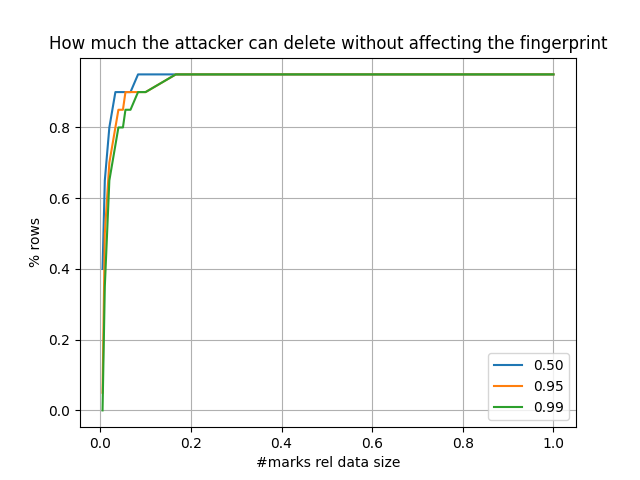

In [13]:
%matplotlib notebook
confidence_rates = [0.50, 0.95, 0.99]
attack_granularity = 0.05
n_experiments = 100
for confidence_rate in confidence_rates:
    file_string = 'inverse_robustness_horizontal_universal_c{}_ag{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       format(attack_granularity,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

In [19]:
robustness_statistical(attack, data, 'horizontal', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.05, confidence_rate=0.99)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.95,
 2: 0.95,
 3: 0.95,
 4: 0.95,
 5: 0.95,
 6: 0.95,
 10: 0.9,
 12: 0.9,
 15: 0.9,
 18: 0.9,
 20: 0.85,
 25: 0.85,
 30: 0.8,
 35: 0.8,
 40: 0.75,
 50: 0.75,
 60: 0.7,
 70: 0.65,
 80: 0.6,
 100: 0.55,
 200: 0.3}

<IPython.core.display.Javascript object>


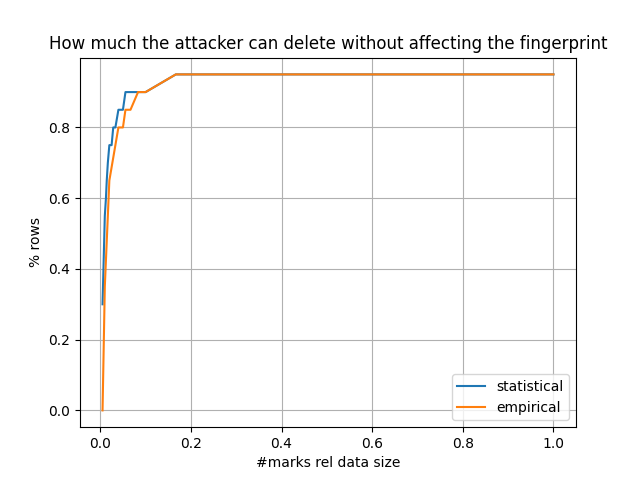

In [21]:
%matplotlib notebook
confidence_rates = [0.99]
attack_granularity= 0.05
for confidence_rate in confidence_rates:
    file_string = 'robustness_stat_horizontal_universal_c{}_ag{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                             format(attack_granularity, ".2f")[-2:])
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= 'statistical')
    #------------------------#
    file_string = 'inverse_robustness_horizontal_universal_c{}_ag{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       format(attack_granularity,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], 
             label= 'empirical')
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.2. Vertical subset attack

In [22]:
attack = VerticalSubsetAttack()

In [25]:
robustness_evaluation(attack, data, 'vertical', gammae=[1,2,3,6,12,20,50,100], 
                      confidence_rate=0.95, target='income', n_experiments=100) 

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=6
Updating results with gamma=12
Updating results with gamma=20
Updating results with gamma=50
Updating results with gamma=100
['native-country', 'occupation', 'hours-per-week', 'age', 'education-num', 'race', 'relationship', 'education', 'fnlwgt', 'capital-loss', 'marital-status', 'sex', 'capital-gain']
Vertical subset attack runtime on 13 out of 14 columns: 0.0010018348693847656 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101120101001011010
Counts:
[[625, 735],
 [737, 741],
 [770, 674],
 [780, 637],
 [679, 747],
 [625, 771],
 [729

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001010001011100011100011111001
Counts:
[[744, 689],
 [622, 686],
 [723, 623],
 [764, 666],
 [645, 793],
 [758, 693],
 [661, 749],
 [743, 690],
 [744, 695],
 [735, 654],
 [657, 709],
 [745, 675],
 [683, 741],
 [647, 758],
 [677, 755],
 [759, 687],
 [743, 623],
 [757, 639],
 [704, 793],
 [694, 775],
 [686, 738],
 [750, 699],
 [731, 584],
 [753, 672],
 [654, 745],
 [655, 760],
 [672, 775],
 [654, 759],
 [629, 768],
 [722, 669],
 [720, 692],
 [692, 745]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'marital-status', 'occupation', 'fnlwgt', 'native-country', 'age', 'workclass', 'relationship', 'capital-loss', 'education-num', 'hours-per-week', 'sex', 'race']
Vertical subset att

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011000010010100111011110100111
Counts:
[[639, 760],
 [681, 731],
 [750, 676],
 [650, 785],
 [663, 775],
 [757, 677],
 [773, 608],
 [739, 658],
 [771, 603],
 [648, 755],
 [758, 685],
 [744, 659],
 [640, 755],
 [751, 685],
 [680, 775],
 [770, 676],
 [778, 668],
 [682, 746],
 [624, 743],
 [660, 699],
 [777, 658],
 [678, 770],
 [715, 775],
 [717, 745],
 [673, 778],
 [797, 618],
 [598, 774],
 [716, 633],
 [726, 673],
 [621, 725],
 [682, 757],
 [587, 752]]
Recipient 1 is suspected.
Runtime: 4 sec.
['marital-status', 'relationship', 'hours-per-week', 'education-num', 'occupation', 'education', 'capital-loss', 'age', 'race', 'fnlwgt', 'workclass', 'capital-gain', 'sex']
Vertical subset attac

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001010110001000111111111110101
Counts:
[[718, 638],
 [783, 661],
 [729, 699],
 [772, 640],
 [626, 741],
 [787, 649],
 [597, 784],
 [741, 668],
 [694, 741],
 [645, 813],
 [745, 677],
 [744, 664],
 [746, 657],
 [664, 797],
 [736, 679],
 [777, 652],
 [739, 694],
 [646, 743],
 [643, 740],
 [666, 752],
 [656, 749],
 [670, 755],
 [619, 713],
 [630, 743],
 [680, 745],
 [631, 789],
 [653, 731],
 [640, 735],
 [774, 642],
 [697, 800],
 [750, 711],
 [664, 758]]
Recipient 1 is suspected.
Runtime: 4 sec.
['capital-loss', 'occupation', 'sex', 'fnlwgt', 'education', 'capital-gain', 'native-country', 'workclass', 'marital-status', 'age', 'hours-per-week', 'race', 'relationship']
Vertical subset atta

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00010010010001110001100011101110
Counts:
[[743, 661],
 [780, 687],
 [748, 619],
 [661, 734],
 [777, 689],
 [732, 663],
 [725, 775],
 [744, 656],
 [795, 660],
 [652, 756],
 [741, 648],
 [745, 670],
 [694, 655],
 [647, 765],
 [660, 737],
 [636, 770],
 [770, 619],
 [709, 668],
 [766, 602],
 [648, 781],
 [624, 745],
 [741, 669],
 [775, 645],
 [784, 657],
 [613, 813],
 [675, 763],
 [644, 775],
 [790, 618],
 [663, 767],
 [633, 796],
 [654, 788],
 [759, 643]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'education', 'fnlwgt', 'education-num', 'hours-per-week', 'relationship', 'age', 'marital-status', 'race', 'occupation', 'capital-loss', 'sex', 'native-country']
Vertical subset att

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100010110110011000101110010100
Counts:
[[715, 763],
 [749, 674],
 [701, 772],
 [756, 658],
 [713, 694],
 [751, 647],
 [624, 748],
 [717, 656],
 [626, 772],
 [641, 778],
 [755, 653],
 [635, 789],
 [651, 751],
 [787, 694],
 [764, 690],
 [705, 778],
 [643, 740],
 [757, 598],
 [727, 677],
 [701, 652],
 [659, 800],
 [728, 633],
 [658, 713],
 [654, 765],
 [634, 788],
 [732, 639],
 [778, 657],
 [690, 756],
 [730, 648],
 [659, 745],
 [777, 660],
 [770, 647]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'sex', 'race', 'age', 'education', 'education-num', 'hours-per-week', 'workclass', 'fnlwgt', 'marital-status', 'native-country', 'capital-gain', 'capital-loss']
Vertical subset a

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11111101101000010110100001100100
Counts:
[[657, 802],
 [679, 751],
 [666, 747],
 [663, 770],
 [648, 774],
 [627, 737],
 [757, 665],
 [654, 831],
 [634, 787],
 [811, 676],
 [627, 742],
 [812, 662],
 [732, 659],
 [722, 613],
 [784, 657],
 [680, 773],
 [730, 679],
 [652, 763],
 [637, 711],
 [757, 663],
 [649, 750],
 [724, 708],
 [761, 665],
 [708, 687],
 [697, 637],
 [664, 751],
 [653, 739],
 [765, 641],
 [727, 669],
 [609, 788],
 [782, 713],
 [709, 635]]
No one suspected.
Runtime: 4 sec.
['race', 'marital-status', 'fnlwgt', 'native-country', 'capital-gain', 'education-num', 'education', 'hours-per-week', 'relationship', 'workclass', 'sex', 'capital-loss', 'age']
Vertical subset attack ru

Potential fingerprint detected: 00111010110000101110000110001001
Counts:
[[825, 605],
 [829, 647],
 [598, 841],
 [590, 754],
 [611, 827],
 [887, 562],
 [664, 766],
 [833, 636],
 [599, 803],
 [591, 824],
 [863, 627],
 [782, 660],
 [796, 561],
 [770, 657],
 [586, 780],
 [828, 616],
 [628, 790],
 [592, 823],
 [602, 770],
 [804, 597],
 [818, 533],
 [796, 581],
 [838, 581],
 [607, 836],
 [616, 847],
 [788, 590],
 [830, 584],
 [808, 605],
 [606, 826],
 [800, 598],
 [789, 564],
 [576, 781]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'education-num', 'workclass', 'occupation', 'relationship', 'fnlwgt', 'capital-loss', 'age', 'capital-gain', 'native-country', 'race', 'marital-status']
Vertical subset attack runtime on 12 out of 14 columns: 0.002000093460083008 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationshi

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000001110101100110100001100111
Counts:
[[779, 658],
 [596, 803],
 [779, 592],
 [800, 595],
 [803, 651],
 [817, 550],
 [781, 637],
 [643, 795],
 [559, 797],
 [628, 824],
 [776, 603],
 [566, 818],
 [797, 628],
 [632, 820],
 [636, 792],
 [822, 631],
 [801, 596],
 [659, 787],
 [614, 812],
 [829, 599],
 [674, 821],
 [794, 594],
 [816, 623],
 [829, 595],
 [778, 571],
 [590, 787],
 [601, 790],
 [818, 588],
 [821, 588],
 [615, 800],
 [624, 769],
 [597, 834]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'education-num', 'capital-gain', 'race', 'marital-status', 'fnlwgt', 'occupation', 'age', 'capital-loss', 'education', 'sex', 'hours-per-week']
Vertical subset attack runtime on 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011101110010011001001000010011
Counts:
[[771, 636],
 [618, 811],
 [822, 544],
 [645, 818],
 [650, 790],
 [581, 802],
 [797, 618],
 [633, 789],
 [605, 871],
 [621, 800],
 [847, 541],
 [841, 653],
 [603, 841],
 [744, 588],
 [788, 628],
 [586, 786],
 [552, 820],
 [824, 606],
 [823, 637],
 [603, 794],
 [751, 622],
 [802, 608],
 [571, 815],
 [820, 625],
 [803, 610],
 [821, 580],
 [849, 637],
 [544, 827],
 [816, 619],
 [816, 580],
 [551, 786],
 [640, 802]]
Recipient 1 is suspected.
Runtime: 4 sec.
['capital-loss', 'capital-gain', 'fnlwgt', 'education-num', 'workclass', 'marital-status', 'native-country', 'age', 'education', 'race', 'occupation', 'hours-per-week']
Vertical subset attack run

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10011000000011010101000001110000
Counts:
[[603, 815],
 [818, 619],
 [796, 628],
 [613, 854],
 [558, 835],
 [823, 611],
 [821, 590],
 [869, 575],
 [755, 578],
 [809, 591],
 [809, 610],
 [802, 574],
 [614, 785],
 [582, 798],
 [808, 606],
 [667, 809],
 [782, 612],
 [577, 816],
 [814, 649],
 [571, 731],
 [827, 624],
 [802, 612],
 [862, 581],
 [788, 625],
 [821, 585],
 [563, 795],
 [620, 817],
 [573, 873],
 [796, 572],
 [840, 651],
 [769, 619],
 [779, 651]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'capital-loss', 'fnlwgt', 'race', 'sex', 'hours-per-week', 'education', 'native-country', 'marital-status', 'relationship', 'education-num', 'age']
Vertical subset attack runtime on

['race', 'marital-status', 'fnlwgt', 'hours-per-week', 'capital-loss', 'education-num', 'occupation', 'sex', 'native-country', 'age', 'relationship', 'education']
Vertical subset attack runtime on 12 out of 14 columns: 0.003987550735473633 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101010010111100111100111100101
Counts:
[[845, 637],
 [801, 579],
 [593, 826],
 [834, 609],
 [596, 790],
 [792, 627],
 [609, 773],
 [763, 588],
 [871, 586],
 [620, 825],
 [860, 625],
 [581, 820],
 [598, 708],
 [605, 773],
 [591, 805],
 [820, 602],
 [795, 649],
 [627, 779],
 [634, 795],
 [593, 803],
 [602, 798],
 [833, 605],
 [793, 650],
 [606, 709],
 [671, 798],
 [573, 871],
 [616, 

Potential fingerprint detected: 00111110111011001001110010001110
Counts:
[[830, 556],
 [769, 622],
 [611, 852],
 [591, 839],
 [617, 773],
 [630, 833],
 [587, 794],
 [789, 646],
 [615, 783],
 [614, 789],
 [601, 714],
 [765, 594],
 [633, 823],
 [586, 838],
 [785, 632],
 [775, 589],
 [586, 836],
 [841, 602],
 [810, 610],
 [627, 770],
 [613, 774],
 [607, 823],
 [781, 610],
 [804, 585],
 [611, 772],
 [773, 644],
 [840, 606],
 [845, 650],
 [625, 827],
 [565, 825],
 [613, 804],
 [842, 626]]
Recipient 1 is suspected.
Runtime: 4 sec.
['age', 'education-num', 'capital-loss', 'fnlwgt', 'relationship', 'marital-status', 'workclass', 'education', 'hours-per-week', 'occupation', 'native-country', 'capital-gain']
Vertical subset attack runtime on 12 out of 14 columns: 0.0019986629486083984 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', '

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001111111101011100100010001011
Counts:
[[590, 837],
 [590, 819],
 [794, 628],
 [769, 587],
 [607, 761],
 [546, 817],
 [624, 794],
 [585, 815],
 [637, 776],
 [620, 824],
 [623, 764],
 [619, 810],
 [794, 612],
 [579, 793],
 [844, 620],
 [584, 825],
 [611, 848],
 [611, 791],
 [810, 607],
 [810, 603],
 [584, 828],
 [785, 659],
 [865, 591],
 [830, 658],
 [598, 793],
 [830, 583],
 [870, 558],
 [766, 611],
 [606, 812],
 [806, 596],
 [581, 848],
 [591, 795]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'race', 'hours-per-week', 'fnlwgt', 'native-country', 'sex', 'education-num', 'occupation', 'capital-loss', 'relationship', 'marital-status', 'capital-gain']
Vertical subset attack 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000101010011101111010111010010
Counts:
[[778, 615],
 [648, 853],
 [793, 607],
 [817, 607],
 [774, 594],
 [605, 760],
 [829, 611],
 [574, 816],
 [828, 595],
 [588, 826],
 [773, 597],
 [857, 558],
 [653, 805],
 [546, 821],
 [613, 852],
 [810, 608],
 [586, 758],
 [604, 836],
 [620, 807],
 [654, 836],
 [759, 581],
 [627, 815],
 [799, 613],
 [598, 837],
 [602, 822],
 [650, 834],
 [768, 577],
 [600, 816],
 [792, 614],
 [767, 592],
 [590, 819],
 [830, 608]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'workclass', 'capital-gain', 'relationship', 'age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'occupation', 'hours-per-week']
Vertical subset attack runtim

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011010011001101001010111101111
Counts:
[[780, 603],
 [610, 781],
 [778, 648],
 [647, 794],
 [579, 855],
 [851, 625],
 [569, 842],
 [831, 629],
 [814, 611],
 [592, 816],
 [614, 793],
 [848, 605],
 [814, 572],
 [609, 806],
 [611, 786],
 [834, 596],
 [625, 804],
 [844, 582],
 [776, 605],
 [590, 746],
 [827, 613],
 [607, 831],
 [799, 580],
 [614, 826],
 [605, 835],
 [616, 772],
 [589, 837],
 [797, 596],
 [648, 824],
 [579, 807],
 [572, 772],
 [583, 778]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'native-country', 'occupation', 'relationship', 'capital-loss', 'education-num', 'sex', 'education', 'race', 'fnlwgt', 'hours-per-week', 'marital-status']
Vertical subset attack run

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111111101001101111011011001100
Counts:
[[827, 610],
 [803, 577],
 [630, 799],
 [604, 832],
 [612, 794],
 [590, 778],
 [582, 775],
 [609, 809],
 [646, 808],
 [794, 626],
 [579, 803],
 [868, 582],
 [784, 589],
 [581, 786],
 [623, 801],
 [825, 618],
 [670, 816],
 [564, 794],
 [603, 818],
 [564, 779],
 [830, 619],
 [619, 801],
 [624, 812],
 [793, 610],
 [589, 817],
 [615, 768],
 [803, 607],
 [822, 593],
 [657, 789],
 [597, 792],
 [807, 638],
 [858, 610]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'sex', 'occupation', 'native-country', 'age', 'race', 'capital-gain', 'marital-status', 'capital-loss', 'fnlwgt', 'hours-per-week', 'education-num']
Vertical subset attack runtim

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100100100110111000010001011001
Counts:
[[596, 839],
 [806, 596],
 [594, 806],
 [818, 566],
 [810, 635],
 [625, 794],
 [821, 615],
 [765, 567],
 [575, 831],
 [843, 565],
 [823, 596],
 [643, 823],
 [601, 855],
 [780, 613],
 [629, 796],
 [614, 793],
 [588, 823],
 [798, 588],
 [867, 624],
 [848, 566],
 [795, 597],
 [585, 732],
 [825, 597],
 [800, 604],
 [822, 657],
 [591, 789],
 [838, 611],
 [574, 838],
 [621, 762],
 [800, 619],
 [818, 613],
 [575, 824]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'native-country', 'workclass', 'fnlwgt', 'occupation', 'age', 'race', 'marital-status', 'capital-loss', 'sex', 'education-num', 'education']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01010011111011110011001001110110
Counts:
[[837, 624],
 [678, 792],
 [771, 633],
 [572, 789],
 [796, 623],
 [813, 589],
 [610, 795],
 [616, 805],
 [628, 795],
 [575, 805],
 [574, 837],
 [767, 586],
 [634, 817],
 [619, 805],
 [605, 794],
 [616, 771],
 [784, 574],
 [834, 548],
 [609, 792],
 [611, 783],
 [775, 620],
 [850, 592],
 [576, 820],
 [812, 628],
 [842, 615],
 [562, 786],
 [595, 797],
 [617, 818],
 [820, 650],
 [630, 806],
 [600, 799],
 [847, 659]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'sex', 'fnlwgt', 'capital-gain', 'capital-loss', 'occupation', 'relationship', 'race', 'marital-status', 'education', 'education-num', 'native-country']
Vertical subset attack runti

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10001101010111011010101101101101
Counts:
[[551, 786],
 [785, 646],
 [859, 609],
 [790, 582],
 [594, 802],
 [592, 790],
 [771, 655],
 [618, 779],
 [843, 574],
 [605, 816],
 [864, 610],
 [597, 771],
 [620, 782],
 [619, 789],
 [841, 620],
 [623, 855],
 [583, 790],
 [803, 609],
 [599, 832],
 [848, 577],
 [593, 806],
 [784, 620],
 [623, 769],
 [597, 817],
 [826, 588],
 [620, 771],
 [636, 796],
 [762, 593],
 [605, 856],
 [643, 821],
 [810, 636],
 [595, 776]]
Recipient 1 is suspected.
Runtime: 4 sec.
['occupation', 'native-country', 'education', 'sex', 'fnlwgt', 'capital-loss', 'race', 'workclass', 'age', 'capital-gain', 'relationship', 'education-num']
Vertical subset attack runtime on 12 ou

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01100111000011101001010010110011
Counts:
[[328, 327],
 [339, 380],
 [359, 392],
 [380, 336],
 [385, 337],
 [321, 367],
 [300, 382],
 [331, 337],
 [383, 355],
 [351, 317],
 [385, 317],
 [406, 308],
 [321, 385],
 [340, 357],
 [319, 391],
 [400, 362],
 [318, 333],
 [380, 323],
 [387, 293],
 [318, 367],
 [380, 334],
 [319, 404],
 [420, 311],
 [398, 319],
 [317, 366],
 [383, 315],
 [321, 375],
 [311, 363],
 [368, 336],
 [378, 331],
 [333, 396],
 [299, 373]]
No one suspected.
Runtime: 3 sec.
['marital-status', 'fnlwgt', 'occupation', 'capital-gain', 'age', 'workclass', 'race', 'hours-per-week', 'education-num', 'sex', 'relationship', 'native-country', 'capital-loss']
Vertical subset attack r

Potential fingerprint detected: 11011011000000111101000111010000
Counts:
[[305, 406],
 [293, 395],
 [419, 295],
 [298, 391],
 [293, 432],
 [402, 327],
 [292, 384],
 [273, 402],
 [407, 346],
 [415, 296],
 [422, 314],
 [422, 293],
 [408, 300],
 [423, 288],
 [305, 421],
 [278, 405],
 [296, 380],
 [312, 428],
 [423, 304],
 [338, 431],
 [383, 311],
 [396, 275],
 [398, 312],
 [291, 410],
 [284, 395],
 [314, 373],
 [441, 319],
 [312, 354],
 [383, 274],
 [401, 293],
 [386, 320],
 [383, 317]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'sex', 'workclass', 'relationship', 'education-num', 'age', 'race', 'capital-loss', 'marital-status', 'native-country', 'education', 'fnlwgt']
Vertical subset attack runtime on 12 out of 14 columns: 0.0020017623901367188 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000101111111010011101101011011
Counts:
[[410, 319],
 [319, 441],
 [371, 306],
 [382, 306],
 [414, 298],
 [302, 421],
 [417, 314],
 [290, 393],
 [291, 414],
 [317, 387],
 [295, 395],
 [271, 382],
 [304, 367],
 [312, 415],
 [382, 300],
 [302, 375],
 [419, 315],
 [411, 297],
 [338, 393],
 [270, 408],
 [294, 409],
 [448, 274],
 [313, 422],
 [313, 408],
 [398, 307],
 [291, 407],
 [394, 293],
 [327, 441],
 [298, 376],
 [442, 299],
 [289, 394],
 [286, 425]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'sex', 'capital-loss', 'capital-gain', 'race', 'education', 'education-num', 'marital-status', 'fnlwgt', 'occupation', 'age', 'relationship']
Vertical subset attack runtime on 12 ou

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00100111011100101011111001111011
Counts:
[[419, 287],
 [394, 306],
 [304, 432],
 [390, 296],
 [401, 286],
 [285, 378],
 [306, 382],
 [315, 420],
 [392, 282],
 [301, 408],
 [321, 402],
 [327, 427],
 [401, 295],
 [415, 291],
 [297, 422],
 [389, 271],
 [296, 408],
 [406, 297],
 [309, 363],
 [323, 402],
 [305, 406],
 [301, 398],
 [287, 406],
 [422, 309],
 [420, 306],
 [310, 429],
 [295, 403],
 [273, 383],
 [273, 404],
 [384, 323],
 [337, 427],
 [285, 425]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'education', 'age', 'sex', 'relationship', 'native-country', 'workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Vertical subset attack runtime on 12

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00100001110111110110101110011001
Counts:
[[417, 286],
 [330, 299],
 [302, 433],
 [444, 299],
 [400, 306],
 [399, 300],
 [446, 309],
 [293, 386],
 [289, 407],
 [315, 398],
 [417, 287],
 [315, 377],
 [282, 419],
 [295, 370],
 [298, 392],
 [318, 376],
 [403, 288],
 [317, 416],
 [275, 408],
 [373, 316],
 [280, 404],
 [367, 314],
 [284, 387],
 [309, 414],
 [291, 421],
 [381, 310],
 [389, 322],
 [273, 388],
 [310, 391],
 [447, 314],
 [420, 317],
 [305, 377]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'hours-per-week', 'education-num', 'sex', 'age', 'education', 'capital-loss', 'capital-gain', 'native-country', 'marital-status', 'workclass', 'occupation']
Vertical subset attack runtim

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001000100111001000011101000111
Counts:
[[379, 303],
 [410, 316],
 [417, 270],
 [408, 308],
 [298, 418],
 [404, 290],
 [377, 317],
 [360, 301],
 [287, 418],
 [420, 323],
 [391, 307],
 [299, 390],
 [316, 431],
 [294, 401],
 [411, 277],
 [400, 274],
 [349, 380],
 [410, 294],
 [385, 318],
 [421, 286],
 [380, 295],
 [290, 420],
 [312, 403],
 [264, 438],
 [405, 301],
 [314, 419],
 [378, 281],
 [425, 297],
 [416, 330],
 [296, 412],
 [299, 409],
 [327, 411]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'occupation', 'hours-per-week', 'workclass', 'native-country', 'marital-status', 'relationship', 'fnlwgt', 'age', 'education-num', 'sex', 'capital-loss']
Vertical subset attack r

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10011000111011110111000101100110
Counts:
[[319, 389],
 [417, 309],
 [414, 293],
 [328, 404],
 [295, 406],
 [417, 307],
 [425, 302],
 [414, 307],
 [304, 442],
 [284, 389],
 [280, 403],
 [396, 307],
 [291, 425],
 [309, 398],
 [332, 412],
 [264, 388],
 [391, 288],
 [313, 433],
 [316, 403],
 [292, 382],
 [427, 319],
 [411, 305],
 [418, 324],
 [295, 396],
 [384, 290],
 [316, 415],
 [311, 398],
 [389, 291],
 [424, 324],
 [281, 418],
 [338, 365],
 [388, 281]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'occupation', 'age', 'sex', 'capital-gain', 'education', 'fnlwgt', 'education-num', 'hours-per-week', 'capital-loss', 'marital-status', 'race']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10000010101001000001011100000100
Counts:
[[310, 370],
 [424, 282],
 [415, 318],
 [436, 333],
 [387, 305],
 [395, 304],
 [336, 415],
 [437, 331],
 [305, 412],
 [434, 315],
 [285, 411],
 [398, 296],
 [399, 303],
 [278, 392],
 [376, 262],
 [390, 300],
 [445, 280],
 [407, 310],
 [407, 291],
 [323, 409],
 [417, 288],
 [286, 427],
 [278, 439],
 [280, 376],
 [432, 278],
 [441, 285],
 [403, 286],
 [396, 283],
 [430, 310],
 [311, 393],
 [434, 285],
 [385, 298]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'relationship', 'race', 'education-num', 'hours-per-week', 'sex', 'occupation', 'workclass', 'education', 'native-country', 'marital-status', 'age']
Vertical subset attack runtime on 1

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01101000110110111010101110111111
Counts:
[[425, 288],
 [266, 404],
 [305, 412],
 [398, 324],
 [293, 410],
 [381, 311],
 [394, 300],
 [368, 318],
 [314, 426],
 [307, 418],
 [398, 293],
 [302, 431],
 [306, 389],
 [424, 323],
 [322, 399],
 [309, 430],
 [324, 378],
 [408, 304],
 [272, 377],
 [393, 289],
 [294, 381],
 [418, 323],
 [293, 414],
 [294, 384],
 [303, 406],
 [393, 304],
 [296, 388],
 [287, 381],
 [297, 441],
 [288, 404],
 [276, 400],
 [280, 385]]
Recipient 1 is suspected.
Runtime: 3 sec.
['sex', 'fnlwgt', 'workclass', 'education', 'relationship', 'education-num', 'marital-status', 'capital-loss', 'race', 'occupation', 'native-country', 'age']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10111011010010010101111001001110
Counts:
[[282, 431],
 [399, 351],
 [300, 388],
 [311, 368],
 [311, 402],
 [418, 275],
 [303, 391],
 [303, 455],
 [411, 297],
 [314, 391],
 [405, 289],
 [453, 305],
 [310, 406],
 [424, 290],
 [383, 302],
 [288, 391],
 [443, 287],
 [351, 411],
 [414, 286],
 [325, 416],
 [354, 417],
 [325, 400],
 [322, 398],
 [435, 292],
 [386, 291],
 [324, 368],
 [423, 288],
 [409, 283],
 [308, 350],
 [284, 388],
 [314, 402],
 [390, 322]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'education-num', 'capital-loss', 'relationship', 'capital-gain', 'fnlwgt', 'marital-status', 'age', 'native-country', 'hours-per-week', 'sex', 'race']
Vertical subset attack runtime

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101111101110100101110010100001
Counts:
[[436, 350],
 [368, 300],
 [287, 382],
 [407, 301],
 [324, 387],
 [292, 383],
 [326, 391],
 [318, 406],
 [254, 376],
 [356, 278],
 [307, 398],
 [309, 417],
 [283, 390],
 [408, 311],
 [342, 396],
 [407, 304],
 [397, 299],
 [331, 407],
 [432, 327],
 [292, 401],
 [309, 411],
 [312, 414],
 [391, 304],
 [405, 314],
 [308, 375],
 [400, 307],
 [326, 398],
 [393, 261],
 [433, 319],
 [414, 296],
 [459, 309],
 [334, 404]]
Recipient 1 is suspected.
Runtime: 4 sec.
['native-country', 'education', 'workclass', 'education-num', 'capital-gain', 'occupation', 'age', 'marital-status', 'capital-loss', 'hours-per-week', 'race', 'fnlwgt']
Vertical subset attack run

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011001011001110010010100001101
Counts:
[[405, 318],
 [318, 389],
 [409, 279],
 [292, 398],
 [298, 408],
 [418, 298],
 [404, 322],
 [300, 411],
 [405, 323],
 [314, 401],
 [322, 433],
 [403, 288],
 [392, 307],
 [343, 437],
 [284, 431],
 [286, 413],
 [389, 296],
 [424, 295],
 [328, 449],
 [381, 315],
 [406, 319],
 [270, 401],
 [428, 283],
 [307, 432],
 [400, 350],
 [429, 288],
 [419, 289],
 [417, 307],
 [274, 417],
 [289, 392],
 [412, 287],
 [270, 370]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'native-country', 'age', 'race', 'marital-status', 'capital-loss', 'workclass', 'sex', 'education-num', 'fnlwgt', 'education', 'capital-gain']
Vertical subset attack runtime on

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101010010001001110101111010001
Counts:
[[384, 282],
 [402, 321],
 [305, 396],
 [381, 266],
 [327, 405],
 [397, 286],
 [295, 395],
 [370, 318],
 [382, 327],
 [293, 411],
 [365, 292],
 [410, 337],
 [456, 293],
 [319, 391],
 [377, 305],
 [399, 296],
 [319, 387],
 [306, 393],
 [305, 415],
 [426, 317],
 [266, 400],
 [414, 309],
 [307, 401],
 [292, 400],
 [301, 391],
 [314, 370],
 [396, 293],
 [302, 400],
 [402, 319],
 [397, 334],
 [387, 318],
 [307, 393]]
Recipient 1 is suspected.
Runtime: 4 sec.
['race', 'fnlwgt', 'workclass', 'education-num', 'capital-gain', 'occupation', 'age', 'marital-status', 'education', 'hours-per-week', 'sex', 'capital-loss']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11110010011001101001011101001110
Counts:
[[223, 259],
 [233, 234],
 [231, 250],
 [253, 256],
 [268, 220],
 [268, 215],
 [211, 255],
 [226, 221],
 [258, 233],
 [221, 258],
 [242, 268],
 [257, 246],
 [236, 189],
 [214, 240],
 [202, 239],
 [227, 206],
 [216, 249],
 [253, 232],
 [273, 227],
 [224, 242],
 [240, 210],
 [224, 244],
 [222, 248],
 [225, 249],
 [285, 196],
 [204, 231],
 [248, 196],
 [245, 225],
 [210, 251],
 [193, 258],
 [230, 272],
 [233, 230]]
No one suspected.
Runtime: 3 sec.
['native-country', 'age', 'workclass', 'capital-loss', 'marital-status', 'fnlwgt', 'education-num', 'race', 'relationship', 'capital-gain', 'hours-per-week', 'occupation', 'education']
Vertical subset at

Potential fingerprint detected: 10111001101000010000001000110010
Counts:
[[188, 242],
 [268, 193],
 [212, 279],
 [198, 291],
 [194, 272],
 [242, 202],
 [282, 194],
 [198, 272],
 [204, 287],
 [255, 193],
 [204, 265],
 [263, 187],
 [272, 207],
 [252, 195],
 [258, 202],
 [204, 266],
 [247, 194],
 [274, 231],
 [286, 230],
 [292, 213],
 [242, 210],
 [287, 216],
 [199, 277],
 [270, 188],
 [274, 232],
 [238, 186],
 [207, 275],
 [184, 257],
 [284, 195],
 [248, 194],
 [211, 230],
 [263, 199]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'sex', 'race', 'fnlwgt', 'marital-status', 'relationship', 'workclass', 'education-num', 'age', 'native-country', 'capital-gain', 'occupation']
Vertical subset attack runtime on 12 out of 14 columns: 0.0019652843475341797 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'rac

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10101011000101110001010000110000
Counts:
[[196, 286],
 [253, 211],
 [212, 317],
 [254, 195],
 [210, 292],
 [256, 198],
 [212, 291],
 [178, 276],
 [294, 215],
 [272, 181],
 [272, 210],
 [231, 259],
 [252, 198],
 [188, 257],
 [185, 241],
 [202, 250],
 [262, 168],
 [258, 219],
 [266, 209],
 [204, 241],
 [276, 189],
 [187, 251],
 [269, 204],
 [262, 218],
 [266, 206],
 [276, 197],
 [194, 269],
 [187, 261],
 [279, 201],
 [271, 187],
 [269, 203],
 [268, 209]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'race', 'native-country', 'capital-loss', 'hours-per-week', 'education', 'fnlwgt', 'occupation', 'education-num', 'sex', 'workclass', 'age']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11111010000100101011000110011001
Counts:
[[218, 283],
 [223, 281],
 [214, 256],
 [217, 270],
 [219, 276],
 [304, 209],
 [205, 273],
 [244, 214],
 [267, 199],
 [285, 208],
 [266, 203],
 [198, 266],
 [274, 202],
 [273, 203],
 [207, 249],
 [242, 213],
 [204, 262],
 [231, 216],
 [205, 282],
 [226, 271],
 [288, 210],
 [261, 199],
 [257, 200],
 [185, 266],
 [221, 280],
 [262, 204],
 [248, 199],
 [192, 248],
 [214, 278],
 [288, 199],
 [270, 208],
 [189, 269]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'age', 'race', 'workclass', 'capital-loss', 'education', 'occupation', 'fnlwgt', 'education-num', 'relationship', 'native-country', 'marital-status']
Vertical subset attack runti

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011001000110001110001010000011
Counts:
[[188, 260],
 [203, 254],
 [257, 229],
 [209, 258],
 [183, 258],
 [273, 188],
 [269, 218],
 [208, 256],
 [312, 201],
 [271, 200],
 [277, 214],
 [198, 313],
 [224, 268],
 [311, 217],
 [278, 199],
 [237, 206],
 [179, 281],
 [189, 297],
 [207, 279],
 [274, 192],
 [285, 218],
 [292, 214],
 [170, 258],
 [279, 196],
 [193, 267],
 [288, 198],
 [274, 187],
 [269, 201],
 [273, 179],
 [293, 202],
 [202, 264],
 [210, 258]]
Recipient 1 is suspected.
Runtime: 4 sec.
['capital-gain', 'relationship', 'capital-loss', 'education-num', 'native-country', 'education', 'workclass', 'age', 'fnlwgt', 'sex', 'marital-status', 'hours-per-week']
Vertical subset attack ru

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01101100101001110010010101010111
Counts:
[[253, 183],
 [195, 278],
 [192, 282],
 [272, 197],
 [213, 301],
 [231, 279],
 [273, 202],
 [272, 170],
 [222, 274],
 [277, 173],
 [193, 269],
 [251, 190],
 [261, 220],
 [212, 270],
 [202, 246],
 [197, 265],
 [271, 190],
 [281, 190],
 [225, 291],
 [246, 197],
 [283, 214],
 [217, 271],
 [260, 204],
 [202, 270],
 [275, 214],
 [192, 263],
 [279, 191],
 [219, 247],
 [230, 213],
 [208, 240],
 [216, 241],
 [208, 307]]
Recipient 1 is suspected.
Runtime: 4 sec.
['race', 'marital-status', 'fnlwgt', 'hours-per-week', 'capital-loss', 'education-num', 'occupation', 'sex', 'native-country', 'age', 'relationship', 'education']
Vertical subset attack runtime o

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111110111011001001110010001110
Counts:
[[273, 201],
 [251, 239],
 [209, 285],
 [185, 311],
 [189, 257],
 [216, 274],
 [211, 279],
 [266, 206],
 [216, 264],
 [206, 257],
 [191, 243],
 [255, 192],
 [205, 261],
 [227, 268],
 [263, 218],
 [247, 203],
 [194, 289],
 [268, 203],
 [285, 199],
 [213, 265],
 [200, 288],
 [195, 268],
 [262, 189],
 [281, 187],
 [196, 234],
 [267, 234],
 [251, 197],
 [270, 206],
 [199, 297],
 [200, 290],
 [225, 269],
 [282, 219]]
Recipient 1 is suspected.
Runtime: 4 sec.
['age', 'education-num', 'capital-loss', 'fnlwgt', 'relationship', 'marital-status', 'workclass', 'education', 'hours-per-week', 'occupation', 'native-country', 'capital-gain']
Vertical subset at

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001111111101011100100010001011
Counts:
[[190, 282],
 [207, 271],
 [267, 230],
 [261, 208],
 [216, 254],
 [177, 274],
 [199, 246],
 [194, 286],
 [217, 259],
 [207, 280],
 [213, 265],
 [187, 290],
 [250, 236],
 [179, 255],
 [280, 204],
 [196, 278],
 [216, 298],
 [197, 250],
 [277, 197],
 [276, 207],
 [211, 271],
 [233, 228],
 [300, 223],
 [279, 227],
 [192, 265],
 [260, 202],
 [280, 193],
 [270, 201],
 [202, 254],
 [276, 216],
 [193, 276],
 [205, 266]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'race', 'hours-per-week', 'fnlwgt', 'native-country', 'sex', 'education-num', 'occupation', 'capital-loss', 'relationship', 'marital-status', 'capital-gain']
Vertical subset attack 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000101010011101111010111010010
Counts:
[[254, 209],
 [226, 312],
 [259, 189],
 [290, 227],
 [260, 193],
 [199, 255],
 [280, 213],
 [198, 255],
 [288, 186],
 [191, 263],
 [255, 201],
 [267, 173],
 [212, 261],
 [200, 267],
 [215, 306],
 [290, 208],
 [190, 247],
 [195, 289],
 [216, 278],
 [224, 287],
 [239, 193],
 [217, 297],
 [258, 203],
 [196, 265],
 [210, 268],
 [214, 269],
 [234, 217],
 [184, 264],
 [265, 195],
 [254, 180],
 [212, 286],
 [279, 212]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'workclass', 'capital-gain', 'relationship', 'age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'occupation', 'hours-per-week']
Vertical subset attack runtim

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011010011001101001010111101111
Counts:
[[288, 207],
 [184, 258],
 [248, 205],
 [235, 282],
 [199, 277],
 [286, 222],
 [205, 272],
 [278, 211],
 [262, 196],
 [189, 261],
 [201, 261],
 [277, 229],
 [290, 186],
 [206, 280],
 [209, 258],
 [264, 202],
 [218, 287],
 [290, 204],
 [245, 210],
 [200, 236],
 [266, 203],
 [191, 275],
 [267, 219],
 [200, 290],
 [194, 269],
 [221, 266],
 [184, 266],
 [268, 207],
 [209, 254],
 [202, 258],
 [178, 255],
 [184, 257]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'native-country', 'occupation', 'relationship', 'capital-loss', 'education-num', 'sex', 'education', 'race', 'fnlwgt', 'hours-per-week', 'marital-status']
Vertical subset attack run

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111111101001101111011011001100
Counts:
[[267, 214],
 [273, 184],
 [215, 251],
 [199, 265],
 [192, 269],
 [173, 255],
 [186, 245],
 [210, 277],
 [228, 275],
 [282, 205],
 [196, 267],
 [311, 207],
 [257, 200],
 [191, 253],
 [211, 263],
 [265, 212],
 [220, 258],
 [177, 255],
 [198, 265],
 [203, 280],
 [299, 204],
 [211, 263],
 [211, 253],
 [272, 192],
 [221, 278],
 [197, 232],
 [264, 183],
 [267, 184],
 [214, 272],
 [184, 273],
 [287, 229],
 [284, 216]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'sex', 'occupation', 'native-country', 'age', 'race', 'capital-gain', 'marital-status', 'capital-loss', 'fnlwgt', 'hours-per-week', 'education-num']
Vertical subset attack runtim

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100100100110111000010001011001
Counts:
[[218, 295],
 [261, 185],
 [206, 272],
 [255, 200],
 [281, 214],
 [187, 252],
 [271, 213],
 [229, 178],
 [188, 286],
 [259, 189],
 [285, 202],
 [213, 268],
 [217, 283],
 [262, 194],
 [189, 262],
 [213, 260],
 [194, 285],
 [290, 190],
 [283, 204],
 [273, 187],
 [272, 202],
 [190, 272],
 [270, 196],
 [286, 197],
 [277, 235],
 [203, 274],
 [293, 188],
 [184, 280],
 [217, 247],
 [277, 221],
 [241, 206],
 [188, 262]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'native-country', 'workclass', 'fnlwgt', 'occupation', 'age', 'race', 'marital-status', 'capital-loss', 'sex', 'education-num', 'education']
Vertical subset attack runtime on 12 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01010011111011110011001001110110
Counts:
[[272, 209],
 [226, 248],
 [276, 220],
 [175, 252],
 [278, 223],
 [276, 179],
 [187, 253],
 [202, 271],
 [209, 269],
 [204, 289],
 [186, 285],
 [242, 189],
 [203, 275],
 [227, 258],
 [186, 287],
 [208, 258],
 [268, 189],
 [260, 172],
 [225, 276],
 [210, 277],
 [261, 211],
 [301, 199],
 [178, 288],
 [280, 211],
 [281, 201],
 [199, 292],
 [211, 256],
 [187, 276],
 [273, 217],
 [173, 268],
 [205, 282],
 [261, 197]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'sex', 'fnlwgt', 'capital-gain', 'capital-loss', 'occupation', 'relationship', 'race', 'marital-status', 'education', 'education-num', 'native-country']
Vertical subset attack runti

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10001101010111011010101101101101
Counts:
[[204, 261],
 [260, 228],
 [297, 197],
 [252, 178],
 [187, 276],
 [202, 277],
 [264, 225],
 [190, 263],
 [273, 182],
 [207, 263],
 [297, 211],
 [200, 260],
 [204, 239],
 [210, 260],
 [246, 216],
 [196, 292],
 [189, 253],
 [265, 205],
 [209, 283],
 [290, 188],
 [215, 259],
 [271, 207],
 [217, 275],
 [202, 285],
 [273, 217],
 [197, 263],
 [195, 266],
 [247, 184],
 [198, 264],
 [214, 264],
 [249, 215],
 [190, 250]]
Recipient 1 is suspected.
Runtime: 4 sec.
['occupation', 'native-country', 'education', 'sex', 'fnlwgt', 'capital-loss', 'race', 'workclass', 'age', 'capital-gain', 'relationship', 'education-num']
Vertical subset attack runtime on 12 ou

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101100101001011010
Counts:
[[93, 122],
 [113, 161],
 [133, 103],
 [147, 96],
 [86, 135],
 [94, 156],
 [129, 83],
 [100, 147],
 [133, 117],
 [106, 162],
 [148, 101],
 [89, 139],
 [105, 120],
 [86, 138],
 [90, 123],
 [131, 110],
 [96, 120],
 [99, 135],
 [131, 113],
 [136, 110],
 [119, 145],
 [139, 95],
 [112, 136],
 [135, 100],
 [131, 94],
 [110, 141],
 [126, 99],
 [106, 131],
 [94, 148],
 [120, 87],
 [92, 119],
 [146, 101]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status', 'occupation', 'hours-per-week', 'age']
Vertical subset attack runtime on 12 out of 14 column

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111000010100000000010110111111
Counts:
[[128, 92],
 [127, 84],
 [107, 134],
 [104, 116],
 [95, 159],
 [159, 99],
 [147, 95],
 [143, 95],
 [144, 94],
 [110, 144],
 [119, 108],
 [116, 123],
 [145, 92],
 [135, 110],
 [142, 100],
 [141, 110],
 [149, 105],
 [151, 104],
 [118, 113],
 [124, 111],
 [137, 91],
 [84, 127],
 [126, 113],
 [103, 122],
 [95, 142],
 [152, 89],
 [100, 124],
 [94, 121],
 [98, 147],
 [102, 140],
 [88, 155],
 [90, 130]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'sex', 'marital-status', 'education-num', 'fnlwgt', 'hours-per-week', 'age', 'race', 'capital-gain', 'education', 'native-country', 'workclass']
Vertical subset attack runtime on 12 out of 14 co

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101100101001011010
Counts:
[[85, 130],
 [99, 175],
 [140, 96],
 [152, 91],
 [78, 143],
 [84, 166],
 [136, 76],
 [94, 153],
 [146, 104],
 [98, 170],
 [155, 94],
 [82, 146],
 [97, 128],
 [81, 143],
 [81, 132],
 [141, 100],
 [91, 125],
 [93, 141],
 [139, 105],
 [142, 104],
 [107, 157],
 [149, 85],
 [97, 151],
 [142, 93],
 [138, 87],
 [98, 153],
 [136, 89],
 [100, 137],
 [85, 157],
 [131, 76],
 [83, 128],
 [156, 91]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status', 'occupation', 'hours-per-week']
Vertical subset attack runtime on 11 out of 14 columns: 0.001966238021

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111000010100000000010110111111
Counts:
[[142, 78],
 [133, 78],
 [102, 139],
 [96, 124],
 [86, 168],
 [167, 91],
 [155, 87],
 [153, 85],
 [149, 89],
 [101, 153],
 [128, 99],
 [107, 132],
 [150, 87],
 [145, 100],
 [148, 94],
 [152, 99],
 [162, 92],
 [159, 96],
 [128, 103],
 [133, 102],
 [146, 82],
 [79, 132],
 [132, 107],
 [89, 136],
 [87, 150],
 [166, 75],
 [94, 130],
 [83, 132],
 [89, 156],
 [95, 147],
 [81, 162],
 [82, 138]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'sex', 'marital-status', 'education-num', 'fnlwgt', 'hours-per-week', 'age', 'race', 'capital-gain', 'education', 'native-country']
Vertical subset attack runtime on 11 out of 14 columns: 0.0030004978179

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00000101001011110101011110001100
Counts:
[[141, 88],
 [146, 92],
 [145, 101],
 [154, 106],
 [148, 114],
 [87, 150],
 [152, 98],
 [87, 152],
 [152, 103],
 [163, 102],
 [92, 155],
 [130, 79],
 [90, 137],
 [108, 151],
 [95, 149],
 [85, 142],
 [128, 81],
 [83, 154],
 [140, 89],
 [78, 138],
 [125, 101],
 [84, 131],
 [89, 140],
 [105, 158],
 [99, 140],
 [150, 100],
 [153, 107],
 [146, 106],
 [94, 124],
 [84, 117],
 [142, 95],
 [134, 87]]
Recipient 1 is suspected.
Runtime: 4 sec.
['race', 'occupation', 'education-num', 'marital-status', 'capital-loss', 'fnlwgt', 'sex', 'age', 'hours-per-week', 'workclass', 'education']
Vertical subset attack runtime on 11 out of 14 columns: 0.0020534992218017

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10111001110000000111001101000000
Counts:
[[101, 141],
 [141, 80],
 [85, 152],
 [97, 185],
 [81, 142],
 [136, 83],
 [155, 110],
 [92, 126],
 [98, 123],
 [96, 149],
 [148, 89],
 [152, 82],
 [161, 91],
 [156, 103],
 [139, 86],
 [131, 78],
 [139, 78],
 [87, 155],
 [88, 149],
 [91, 146],
 [134, 101],
 [161, 105],
 [84, 135],
 [93, 151],
 [151, 87],
 [89, 156],
 [157, 91],
 [144, 92],
 [163, 95],
 [148, 73],
 [137, 80],
 [133, 73]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'hours-per-week', 'age', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country', 'fnlwgt', 'race', 'marital-status']
Vertical subset attack runtime on 11 out of 14 columns: 0.00199913

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001111001100000001001111011001
Counts:
[[141, 86],
 [145, 104],
 [137, 105],
 [143, 81],
 [70, 151],
 [86, 144],
 [105, 144],
 [87, 156],
 [157, 98],
 [153, 86],
 [103, 152],
 [103, 145],
 [135, 87],
 [141, 84],
 [140, 99],
 [135, 82],
 [125, 91],
 [157, 93],
 [140, 88],
 [93, 124],
 [155, 92],
 [141, 101],
 [96, 156],
 [93, 130],
 [112, 141],
 [96, 159],
 [137, 86],
 [96, 128],
 [97, 144],
 [137, 85],
 [142, 87],
 [104, 143]]
Recipient 1 is suspected.
Runtime: 3 sec.
['sex', 'fnlwgt', 'capital-gain', 'education', 'education-num', 'relationship', 'hours-per-week', 'marital-status', 'native-country', 'occupation', 'race']
Vertical subset attack runtime on 11 out of 14 columns: 0.00200

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001110010001001100100101001001
Counts:
[[88, 147],
 [85, 134],
 [139, 96],
 [154, 105],
 [100, 144],
 [93, 130],
 [103, 133],
 [128, 100],
 [134, 78],
 [97, 146],
 [161, 112],
 [138, 92],
 [149, 85],
 [98, 129],
 [146, 97],
 [140, 101],
 [105, 132],
 [108, 147],
 [143, 87],
 [136, 115],
 [101, 175],
 [107, 91],
 [151, 87],
 [92, 159],
 [131, 112],
 [88, 147],
 [130, 96],
 [147, 75],
 [86, 137],
 [135, 89],
 [139, 81],
 [98, 155]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'marital-status', 'education', 'fnlwgt', 'native-country', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'relationship', 'age']
Vertical subset attack runtime on 11 out of 14 columns: 0.00

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100100111110110011101000001101
Counts:
[[82, 139],
 [148, 92],
 [108, 142],
 [150, 82],
 [135, 92],
 [96, 142],
 [152, 94],
 [153, 101],
 [105, 138],
 [87, 136],
 [96, 145],
 [107, 131],
 [120, 144],
 [158, 84],
 [83, 134],
 [94, 144],
 [155, 88],
 [144, 93],
 [93, 153],
 [83, 147],
 [80, 147],
 [133, 104],
 [106, 133],
 [142, 77],
 [129, 95],
 [157, 107],
 [132, 88],
 [147, 91],
 [100, 144],
 [103, 140],
 [150, 110],
 [94, 148]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'marital-status', 'occupation', 'native-country', 'hours-per-week', 'race', 'age', 'sex', 'relationship', 'fnlwgt', 'capital-gain']
Vertical subset attack runtime on 11 out of 14 columns: 0.002001762390

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11110010011001010100000000001011
Counts:
[[88, 163],
 [88, 143],
 [95, 122],
 [98, 149],
 [148, 87],
 [152, 92],
 [90, 149],
 [146, 102],
 [147, 106],
 [86, 139],
 [86, 114],
 [143, 110],
 [148, 105],
 [88, 164],
 [155, 93],
 [87, 166],
 [133, 104],
 [81, 130],
 [128, 85],
 [132, 86],
 [124, 83],
 [170, 83],
 [151, 89],
 [131, 99],
 [141, 106],
 [137, 89],
 [138, 106],
 [139, 99],
 [88, 143],
 [145, 89],
 [72, 139],
 [94, 166]]
Recipient 1 is suspected.
Runtime: 3 sec.
['age', 'marital-status', 'sex', 'capital-loss', 'native-country', 'education', 'hours-per-week', 'race', 'fnlwgt', 'occupation', 'education-num']
Vertical subset attack runtime on 11 out of 14 columns: 0.002000331878662

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11111100011011110111110101010011
Counts:
[[96, 151],
 [91, 134],
 [80, 139],
 [88, 132],
 [98, 134],
 [103, 137],
 [180, 101],
 [156, 88],
 [153, 101],
 [93, 143],
 [90, 141],
 [120, 100],
 [84, 129],
 [91, 162],
 [94, 131],
 [89, 135],
 [141, 100],
 [89, 123],
 [102, 144],
 [104, 159],
 [83, 151],
 [109, 124],
 [114, 75],
 [86, 159],
 [139, 84],
 [101, 130],
 [145, 89],
 [98, 141],
 [136, 93],
 [123, 85],
 [94, 131],
 [89, 134]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'education-num', 'hours-per-week', 'race', 'education', 'relationship', 'capital-gain', 'capital-loss', 'sex', 'native-country', 'fnlwgt']
Vertical subset attack runtime on 11 out of 14 columns: 0.001999

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00010010011011101000000001111000
Counts:
[[134, 82],
 [143, 105],
 [147, 100],
 [88, 125],
 [139, 98],
 [142, 96],
 [101, 163],
 [142, 94],
 [135, 86],
 [110, 143],
 [106, 152],
 [150, 76],
 [75, 144],
 [97, 157],
 [94, 132],
 [154, 92],
 [90, 148],
 [144, 86],
 [127, 83],
 [164, 79],
 [124, 93],
 [148, 87],
 [146, 96],
 [144, 78],
 [138, 94],
 [81, 144],
 [100, 144],
 [102, 119],
 [75, 138],
 [141, 94],
 [137, 100],
 [149, 89]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'workclass', 'race', 'relationship', 'sex', 'fnlwgt', 'capital-gain', 'capital-loss', 'native-country', 'age', 'education']
Vertical subset attack runtime on 11 out of 14 columns: 0.0020003318786621094

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00100110011001110010010110000101
Counts:
[[148, 97],
 [152, 73],
 [110, 120],
 [140, 111],
 [143, 91],
 [83, 139],
 [98, 153],
 [154, 93],
 [161, 97],
 [87, 160],
 [92, 135],
 [151, 78],
 [153, 86],
 [87, 138],
 [88, 156],
 [103, 153],
 [153, 100],
 [130, 109],
 [92, 138],
 [150, 103],
 [138, 104],
 [100, 119],
 [160, 81],
 [98, 144],
 [72, 139],
 [139, 91],
 [137, 83],
 [145, 101],
 [139, 88],
 [107, 127],
 [145, 88],
 [85, 109]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'relationship', 'marital-status', 'native-country', 'capital-gain', 'occupation', 'hours-per-week', 'sex', 'age', 'workclass', 'education-num']
Vertical subset attack runtime on 11 out of 14 columns: 0.001958

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01100000001011011110010001101010
Counts:
[[129, 87],
 [98, 162],
 [95, 144],
 [137, 86],
 [149, 97],
 [135, 81],
 [158, 100],
 [125, 91],
 [131, 86],
 [150, 85],
 [87, 124],
 [143, 94],
 [90, 147],
 [102, 144],
 [132, 91],
 [88, 140],
 [83, 158],
 [98, 136],
 [95, 147],
 [133, 114],
 [129, 94],
 [94, 135],
 [152, 77],
 [142, 99],
 [150, 92],
 [78, 143],
 [110, 167],
 [128, 106],
 [99, 146],
 [166, 97],
 [88, 154],
 [136, 98]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'hours-per-week', 'sex', 'education-num', 'fnlwgt', 'marital-status', 'native-country', 'relationship', 'education', 'capital-loss', 'occupation']
Vertical subset attack runtime on 11 out of 14 columns: 0.001

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00000110100111100100101101111101
Counts:
[[144, 83],
 [144, 100],
 [139, 107],
 [132, 94],
 [154, 99],
 [85, 132],
 [94, 149],
 [146, 90],
 [82, 144],
 [148, 101],
 [138, 91],
 [110, 153],
 [93, 156],
 [90, 152],
 [92, 134],
 [125, 115],
 [135, 89],
 [73, 144],
 [135, 98],
 [158, 94],
 [97, 140],
 [132, 93],
 [96, 150],
 [101, 146],
 [147, 91],
 [99, 139],
 [98, 144],
 [90, 148],
 [74, 169],
 [84, 157],
 [182, 89],
 [97, 128]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'occupation', 'marital-status', 'age', 'sex', 'capital-gain', 'race', 'relationship', 'capital-loss', 'fnlwgt', 'education-num']
Vertical subset attack runtime on 11 out of 14 columns: 0.0030336380004882812 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11101001010201010002101110010011
Counts:
[[43, 46],
 [61, 62],
 [43, 52],
 [56, 54],
 [59, 72],
 [58, 55],
 [57, 52],
 [49, 65],
 [63, 60],
 [46, 55],
 [57, 56],
 [62, 62],
 [68, 54],
 [59, 73],
 [62, 58],
 [51, 64],
 [67, 49],
 [51, 50],
 [61, 45],
 [70, 70],
 [52, 75],
 [67, 49],
 [62, 79],
 [56, 66],
 [45, 65],
 [56, 54],
 [63, 48],
 [50, 58],
 [67, 60],
 [74, 55],
 [53, 72],
 [55, 65]]
No one suspected.
Runtime: 3 sec.
['sex', 'education-num', 'capital-loss', 'marital-status', 'race', 'age', 'relationship', 'occupation', 'workclass', 'native-country', 'capital-gain', 'hours-per-week', 'education']
Vertical subset attack runtime on 13 out of 14 columns: 0.002001047134399414 sec.
Sta

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10000111000011101001010010110011
Counts:
[[57, 62],
 [64, 58],
 [60, 56],
 [59, 44],
 [73, 42],
 [48, 76],
 [49, 88],
 [40, 61],
 [80, 52],
 [56, 47],
 [75, 46],
 [69, 51],
 [55, 75],
 [61, 62],
 [63, 79],
 [68, 62],
 [43, 58],
 [75, 44],
 [83, 43],
 [59, 61],
 [66, 50],
 [57, 64],
 [64, 43],
 [75, 49],
 [51, 71],
 [73, 42],
 [45, 60],
 [50, 79],
 [61, 56],
 [63, 55],
 [61, 74],
 [42, 62]]
No one suspected.
Runtime: 3 sec.
-------------------------------------------------------------------
-------------------------------------------------------------------
Attack with strength 12 is too strong. Halting after 6 iterations.
----------------------------------------------------------------

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001010001011100011100011111001
Counts:
[[72, 38],
 [47, 51],
 [60, 37],
 [72, 55],
 [38, 60],
 [72, 48],
 [41, 56],
 [68, 54],
 [91, 40],
 [70, 45],
 [41, 78],
 [59, 39],
 [50, 66],
 [47, 68],
 [46, 60],
 [80, 38],
 [70, 55],
 [69, 52],
 [58, 84],
 [41, 85],
 [45, 67],
 [64, 41],
 [62, 37],
 [69, 45],
 [37, 74],
 [47, 76],
 [48, 83],
 [44, 65],
 [37, 52],
 [66, 47],
 [72, 48],
 [55, 75]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'marital-status', 'occupation', 'fnlwgt', 'native-country', 'age', 'workclass', 'relationship', 'capital-loss', 'education-num', 'hours-per-week']
Vertical subset attack runtime on 11 out of 14 columns: 0.0030014514923095703 sec.
Start detection

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011000010010100111011110120111
Counts:
[[39, 70],
 [41, 60],
 [69, 47],
 [43, 85],
 [48, 69],
 [67, 62],
 [72, 45],
 [68, 32],
 [82, 39],
 [42, 76],
 [91, 51],
 [79, 42],
 [39, 65],
 [88, 54],
 [49, 73],
 [71, 53],
 [81, 42],
 [50, 66],
 [46, 59],
 [56, 74],
 [86, 42],
 [39, 85],
 [51, 67],
 [56, 68],
 [44, 68],
 [71, 41],
 [45, 60],
 [55, 55],
 [66, 53],
 [42, 67],
 [33, 76],
 [48, 84]]
No one suspected.
Runtime: 3 sec.
['marital-status', 'relationship', 'hours-per-week', 'education-num', 'occupation', 'education', 'capital-loss', 'age', 'race', 'fnlwgt', 'workclass']
Vertical subset attack runtime on 11 out of 14 columns: 0.0029952526092529297 sec.
Start detection algorithm...
	gam

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10001010110001000111111111110101
Counts:
[[56, 60],
 [83, 58],
 [72, 46],
 [81, 46],
 [52, 73],
 [70, 52],
 [39, 61],
 [69, 50],
 [43, 76],
 [37, 91],
 [61, 45],
 [70, 45],
 [83, 48],
 [55, 67],
 [70, 38],
 [72, 53],
 [79, 57],
 [50, 75],
 [43, 70],
 [40, 74],
 [46, 71],
 [47, 75],
 [43, 64],
 [53, 66],
 [44, 75],
 [48, 70],
 [41, 57],
 [41, 75],
 [57, 38],
 [61, 74],
 [60, 44],
 [43, 69]]
No one suspected.
Runtime: 3 sec.
-------------------------------------------------------------------
-------------------------------------------------------------------
Attack with strength 11 is too strong. Halting after 23 iterations.
---------------------------------------------------------------

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001010001011100011100011111001
Counts:
[[75, 35],
 [44, 54],
 [63, 34],
 [78, 49],
 [32, 66],
 [78, 42],
 [37, 60],
 [71, 51],
 [97, 34],
 [72, 43],
 [39, 80],
 [60, 38],
 [45, 71],
 [42, 73],
 [43, 63],
 [83, 35],
 [77, 48],
 [74, 47],
 [49, 93],
 [37, 89],
 [41, 71],
 [68, 37],
 [63, 36],
 [73, 41],
 [32, 79],
 [40, 83],
 [45, 86],
 [40, 69],
 [33, 56],
 [72, 41],
 [74, 46],
 [51, 79]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'marital-status', 'occupation', 'fnlwgt', 'native-country', 'age', 'workclass', 'relationship', 'capital-loss', 'education-num']
Vertical subset attack runtime on 10 out of 14 columns: 0.002000570297241211 sec.
Start detection algorithm...
	gamm

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011000010010100111011110100111
Counts:
[[36, 73],
 [39, 62],
 [71, 45],
 [40, 88],
 [44, 73],
 [74, 55],
 [76, 41],
 [70, 30],
 [84, 37],
 [37, 81],
 [97, 45],
 [80, 41],
 [32, 72],
 [90, 52],
 [44, 78],
 [77, 47],
 [86, 37],
 [45, 71],
 [42, 63],
 [53, 77],
 [91, 37],
 [35, 89],
 [47, 71],
 [52, 72],
 [41, 71],
 [74, 38],
 [43, 62],
 [58, 52],
 [68, 51],
 [40, 69],
 [27, 82],
 [44, 88]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'relationship', 'hours-per-week', 'education-num', 'occupation', 'education', 'capital-loss', 'age', 'race', 'fnlwgt']
Vertical subset attack runtime on 10 out of 14 columns: 0.003000020980834961 sec.
Start detection algorithm...
	gamma: 12

Potential fingerprint detected: 10001010110001000111111111110101
Counts:
[[57, 59],
 [89, 52],
 [76, 42],
 [85, 42],
 [47, 78],
 [72, 50],
 [36, 64],
 [70, 49],
 [42, 77],
 [31, 97],
 [66, 40],
 [72, 43],
 [89, 42],
 [52, 70],
 [74, 34],
 [75, 50],
 [86, 50],
 [44, 81],
 [39, 74],
 [36, 78],
 [39, 78],
 [41, 81],
 [38, 69],
 [49, 70],
 [42, 77],
 [42, 76],
 [39, 59],
 [37, 79],
 [60, 35],
 [53, 82],
 [63, 41],
 [39, 73]]
No one suspected.
Runtime: 3 sec.
['capital-loss', 'occupation', 'sex', 'fnlwgt', 'education', 'capital-gain', 'native-country', 'workclass', 'marital-status', 'age']
Vertical subset attack runtime on 10 out of 14 columns: 0.0020012855529785156 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dty

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001111001100000001001111011001
Counts:
[[78, 34],
 [76, 47],
 [71, 47],
 [63, 45],
 [38, 79],
 [41, 77],
 [50, 76],
 [41, 80],
 [84, 36],
 [82, 38],
 [49, 81],
 [44, 76],
 [74, 46],
 [82, 38],
 [75, 43],
 [69, 39],
 [66, 48],
 [95, 38],
 [75, 41],
 [40, 64],
 [79, 41],
 [61, 47],
 [49, 88],
 [38, 77],
 [53, 76],
 [42, 74],
 [63, 43],
 [50, 70],
 [41, 72],
 [74, 45],
 [61, 44],
 [42, 79]]
Recipient 1 is suspected.
Runtime: 3 sec.
['sex', 'fnlwgt', 'capital-gain', 'education', 'education-num', 'relationship', 'hours-per-week', 'marital-status', 'native-country', 'occupation']
Vertical subset attack runtime on 10 out of 14 columns: 0.002000570297241211 sec.
Start detection algorithm...


	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001110010001001100100101001001
Counts:
[[35, 69],
 [36, 64],
 [72, 36],
 [80, 47],
 [48, 82],
 [37, 69],
 [44, 65],
 [72, 49],
 [70, 43],
 [51, 75],
 [95, 46],
 [72, 46],
 [94, 48],
 [45, 67],
 [76, 43],
 [77, 48],
 [48, 67],
 [47, 84],
 [76, 36],
 [69, 57],
 [44, 105],
 [63, 42],
 [88, 41],
 [48, 81],
 [64, 59],
 [40, 82],
 [80, 40],
 [68, 38],
 [37, 79],
 [68, 38],
 [77, 32],
 [41, 87]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'marital-status', 'education', 'fnlwgt', 'native-country', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'relationship']
Vertical subset attack runtime on 10 out of 14 columns: 0.0029952526092529297 sec.
Start detection algorithm.

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100100111110110011101000001101
Counts:
[[36, 84],
 [78, 36],
 [42, 69],
 [65, 35],
 [79, 40],
 [39, 66],
 [61, 56],
 [83, 46],
 [48, 80],
 [44, 62],
 [49, 79],
 [42, 79],
 [61, 69],
 [86, 43],
 [41, 64],
 [43, 75],
 [82, 36],
 [91, 45],
 [36, 83],
 [34, 72],
 [37, 81],
 [78, 49],
 [46, 77],
 [72, 41],
 [80, 43],
 [82, 49],
 [71, 55],
 [68, 47],
 [44, 68],
 [50, 81],
 [82, 50],
 [44, 94]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'marital-status', 'occupation', 'native-country', 'hours-per-week', 'race', 'age', 'sex', 'relationship', 'fnlwgt']
Vertical subset attack runtime on 10 out of 14 columns: 0.0020024776458740234 sec.
Start detection algorithm...
	gamma: 12
	finge

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11110010011001010100000000001011
Counts:
[[49, 89],
 [35, 81],
 [44, 70],
 [42, 95],
 [83, 36],
 [86, 46],
 [38, 79],
 [80, 48],
 [60, 44],
 [28, 74],
 [40, 54],
 [84, 48],
 [92, 40],
 [40, 87],
 [82, 49],
 [43, 89],
 [76, 44],
 [38, 75],
 [76, 38],
 [64, 40],
 [70, 39],
 [95, 34],
 [95, 45],
 [58, 40],
 [80, 39],
 [70, 33],
 [71, 49],
 [75, 46],
 [33, 86],
 [59, 41],
 [32, 70],
 [48, 78]]
Recipient 1 is suspected.
Runtime: 3 sec.
['age', 'marital-status', 'sex', 'capital-loss', 'native-country', 'education', 'hours-per-week', 'race', 'fnlwgt', 'occupation']
Vertical subset attack runtime on 10 out of 14 columns: 0.0029909610748291016 sec.
Start detection algorithm...
	gamma: 12
	finge

Potential fingerprint detected: 11111100011011110111110101010011
Counts:
[[39, 78],
 [47, 76],
 [33, 74],
 [33, 68],
 [53, 61],
 [45, 79],
 [94, 47],
 [99, 37],
 [76, 47],
 [36, 72],
 [43, 82],
 [63, 55],
 [37, 64],
 [45, 81],
 [44, 65],
 [43, 69],
 [76, 43],
 [45, 83],
 [41, 74],
 [41, 86],
 [39, 77],
 [43, 60],
 [58, 35],
 [35, 77],
 [77, 38],
 [38, 72],
 [77, 39],
 [47, 82],
 [73, 42],
 [58, 32],
 [41, 71],
 [33, 66]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'education-num', 'hours-per-week', 'race', 'education', 'relationship', 'capital-gain', 'capital-loss', 'sex', 'native-country']
Vertical subset attack runtime on 10 out of 14 columns: 0.0030176639556884766 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-c

Potential fingerprint detected: 00010010011011101000000001111000
Counts:
[[61, 43],
 [72, 53],
 [78, 42],
 [36, 58],
 [71, 41],
 [73, 57],
 [39, 89],
 [80, 42],
 [76, 35],
 [46, 80],
 [58, 78],
 [89, 35],
 [34, 73],
 [41, 80],
 [39, 59],
 [85, 45],
 [31, 82],
 [78, 39],
 [60, 35],
 [88, 36],
 [68, 44],
 [90, 31],
 [87, 43],
 [81, 30],
 [70, 40],
 [31, 69],
 [38, 76],
 [49, 59],
 [31, 74],
 [65, 45],
 [69, 45],
 [75, 37]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'workclass', 'race', 'relationship', 'sex', 'fnlwgt', 'capital-gain', 'capital-loss', 'native-country', 'age']
Vertical subset attack runtime on 10 out of 14 columns: 0.0030002593994140625 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
     

Potential fingerprint detected: 00100110011001110010010110000101
Counts:
[[66, 44],
 [80, 27],
 [46, 58],
 [71, 49],
 [75, 33],
 [32, 73],
 [39, 82],
 [95, 37],
 [89, 44],
 [43, 91],
 [42, 72],
 [88, 35],
 [78, 36],
 [37, 70],
 [35, 84],
 [39, 83],
 [81, 49],
 [66, 61],
 [41, 62],
 [79, 46],
 [57, 55],
 [38, 63],
 [81, 31],
 [49, 72],
 [38, 67],
 [77, 43],
 [65, 37],
 [81, 38],
 [79, 40],
 [43, 70],
 [75, 35],
 [37, 50]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'relationship', 'marital-status', 'native-country', 'capital-gain', 'occupation', 'hours-per-week', 'sex', 'age', 'workclass']
Vertical subset attack runtime on 10 out of 14 columns: 0.002997159957885742 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],

Potential fingerprint detected: 01100000001011011110010001101010
Counts:
[[63, 38],
 [45, 96],
 [33, 76],
 [86, 37],
 [74, 40],
 [73, 36],
 [86, 44],
 [69, 34],
 [61, 43],
 [86, 33],
 [42, 64],
 [73, 39],
 [44, 71],
 [47, 76],
 [63, 41],
 [31, 75],
 [42, 78],
 [50, 73],
 [42, 83],
 [68, 40],
 [79, 41],
 [42, 72],
 [85, 34],
 [76, 44],
 [65, 37],
 [33, 75],
 [53, 93],
 [66, 44],
 [44, 69],
 [93, 51],
 [41, 76],
 [71, 45]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'hours-per-week', 'sex', 'education-num', 'fnlwgt', 'marital-status', 'native-country', 'relationship', 'education', 'capital-loss']
Vertical subset attack runtime on 10 out of 14 columns: 0.002035379409790039 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native

Potential fingerprint detected: 00000110100111100100101101111101
Counts:
[[75, 30],
 [65, 39],
 [73, 57],
 [66, 47],
 [79, 35],
 [35, 72],
 [48, 88],
 [80, 37],
 [38, 75],
 [79, 45],
 [78, 38],
 [54, 85],
 [40, 87],
 [38, 81],
 [37, 77],
 [63, 48],
 [71, 49],
 [37, 76],
 [80, 38],
 [73, 56],
 [47, 72],
 [75, 36],
 [34, 85],
 [54, 73],
 [70, 33],
 [55, 72],
 [37, 72],
 [36, 84],
 [36, 92],
 [45, 94],
 [100, 37],
 [39, 60]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'occupation', 'marital-status', 'age', 'sex', 'capital-gain', 'race', 'relationship', 'capital-loss', 'fnlwgt']
Vertical subset attack runtime on 10 out of 14 columns: 0.0030062198638916016 sec.
Start detection algorithm...
	gamma: 12
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      d

Potential fingerprint detected: 11101101200001211201101111011001
Counts:
[[28, 34],
 [39, 42],
 [26, 36],
 [33, 30],
 [38, 41],
 [39, 44],
 [28, 25],
 [31, 33],
 [35, 35],
 [36, 28],
 [42, 32],
 [40, 38],
 [34, 28],
 [32, 43],
 [39, 39],
 [31, 39],
 [25, 30],
 [32, 32],
 [30, 25],
 [35, 37],
 [33, 39],
 [33, 28],
 [32, 39],
 [37, 41],
 [27, 50],
 [35, 38],
 [41, 36],
 [34, 50],
 [32, 40],
 [41, 28],
 [40, 36],
 [31, 37]]
No one suspected.
Runtime: 3 sec.
['sex', 'education-num', 'capital-loss', 'marital-status', 'race', 'age', 'relationship', 'occupation', 'workclass', 'native-country', 'capital-gain', 'hours-per-week', 'education']
Vertical subset attack runtime on 13 out of 14 columns: 0.0009989738464355469 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010011101100101001011010
Counts:
[[17, 46],
 [31, 56],
 [46, 29],
 [62, 34],
 [22, 47],
 [22, 31],
 [41, 19],
 [32, 48],
 [40, 32],
 [31, 51],
 [55, 32],
 [37, 34],
 [31, 38],
 [22, 49],
 [26, 42],
 [42, 34],
 [25, 35],
 [27, 38],
 [45, 28],
 [30, 25],
 [31, 51],
 [47, 29],
 [35, 55],
 [37, 25],
 [43, 34],
 [31, 48],
 [43, 27],
 [31, 40],
 [29, 46],
 [42, 31],
 [27, 51],
 [39, 24]]
No one suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status', 'occupation', 'hours-per-week']
Vertical subset attack runtime on 11 out of 14 columns: 0.0019960403442382812 sec.
Start detection algorithm...
	gam

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10111000010100000000010110111111
Counts:
[[28, 29],
 [41, 28],
 [23, 37],
 [30, 45],
 [23, 43],
 [39, 31],
 [33, 30],
 [50, 25],
 [36, 27],
 [30, 35],
 [62, 35],
 [24, 48],
 [46, 23],
 [41, 28],
 [40, 31],
 [41, 26],
 [35, 28],
 [46, 29],
 [36, 26],
 [50, 30],
 [46, 19],
 [31, 41],
 [48, 27],
 [30, 43],
 [15, 35],
 [39, 24],
 [33, 42],
 [38, 45],
 [30, 35],
 [20, 37],
 [25, 39],
 [30, 41]]
No one suspected.
Runtime: 3 sec.
['relationship', 'sex', 'marital-status', 'education-num', 'fnlwgt', 'hours-per-week', 'age', 'race', 'capital-gain', 'education', 'native-country']
Vertical subset attack runtime on 11 out of 14 columns: 0.0020186901092529297 sec.
Start detection algorithm...
	gamma

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11100111000011101001010010110011
Counts:
[[16, 36],
 [31, 39],
 [26, 64],
 [45, 30],
 [54, 21],
 [18, 48],
 [22, 49],
 [18, 36],
 [41, 21],
 [45, 15],
 [39, 21],
 [39, 24],
 [23, 54],
 [32, 33],
 [22, 51],
 [47, 35],
 [16, 41],
 [51, 34],
 [48, 34],
 [28, 34],
 [43, 24],
 [28, 51],
 [46, 17],
 [58, 25],
 [25, 43],
 [44, 22],
 [30, 51],
 [20, 48],
 [40, 28],
 [49, 16],
 [29, 48],
 [28, 38]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'fnlwgt', 'occupation', 'capital-gain', 'age', 'workclass', 'race', 'hours-per-week', 'education-num', 'sex']
Vertical subset attack runtime on 10 out of 14 columns: 0.006005287170410156 sec.
Start detection algorithm...
	gamma: 20
	fingerp

Potential fingerprint detected: 10000110001010101110010011000001
Counts:
[[27, 35],
 [52, 29],
 [44, 26],
 [51, 14],
 [60, 28],
 [23, 42],
 [21, 42],
 [48, 20],
 [34, 25],
 [37, 20],
 [30, 58],
 [54, 28],
 [23, 58],
 [40, 26],
 [29, 52],
 [57, 29],
 [20, 46],
 [24, 51],
 [20, 41],
 [58, 24],
 [40, 24],
 [26, 41],
 [42, 26],
 [43, 19],
 [23, 49],
 [20, 41],
 [44, 29],
 [44, 29],
 [42, 19],
 [40, 32],
 [39, 20],
 [28, 43]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'age', 'race', 'hours-per-week', 'fnlwgt', 'native-country', 'capital-gain', 'relationship', 'marital-status', 'workclass']
Vertical subset attack runtime on 10 out of 14 columns: 0.002001523971557617 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101100101001011010
Counts:
[[13, 50],
 [28, 59],
 [51, 24],
 [66, 30],
 [18, 51],
 [17, 36],
 [44, 16],
 [26, 54],
 [47, 25],
 [23, 59],
 [60, 27],
 [30, 41],
 [23, 46],
 [18, 53],
 [21, 47],
 [47, 29],
 [21, 39],
 [23, 42],
 [51, 22],
 [35, 20],
 [26, 56],
 [49, 27],
 [30, 60],
 [40, 22],
 [46, 31],
 [26, 53],
 [50, 20],
 [23, 48],
 [23, 52],
 [48, 25],
 [22, 56],
 [41, 22]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status']
Vertical subset attack runtime on 9 out of 14 columns: 0.0029647350311279297 sec.
Start detection algorithm...
	gamma: 20
	fingerprint lengt

Potential fingerprint detected: 00111000010100000000010110111111
Counts:
[[31, 26],
 [42, 27],
 [19, 41],
 [25, 50],
 [22, 44],
 [45, 25],
 [39, 24],
 [55, 20],
 [42, 21],
 [26, 39],
 [70, 27],
 [19, 53],
 [52, 17],
 [48, 21],
 [48, 23],
 [42, 25],
 [38, 25],
 [52, 23],
 [41, 21],
 [54, 26],
 [51, 14],
 [27, 45],
 [50, 25],
 [26, 47],
 [12, 38],
 [45, 18],
 [24, 51],
 [34, 49],
 [26, 39],
 [19, 38],
 [21, 43],
 [27, 44]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'sex', 'marital-status', 'education-num', 'fnlwgt', 'hours-per-week', 'age', 'race', 'capital-gain']
Vertical subset attack runtime on 9 out of 14 columns: 0.003056049346923828 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='objec

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001011000101101100011100001001
Counts:
[[18, 38],
 [20, 48],
 [56, 26],
 [53, 21],
 [20, 35],
 [51, 31],
 [22, 58],
 [19, 44],
 [61, 21],
 [40, 21],
 [55, 17],
 [14, 45],
 [55, 15],
 [26, 42],
 [26, 53],
 [34, 19],
 [18, 49],
 [30, 42],
 [51, 23],
 [61, 23],
 [60, 31],
 [21, 42],
 [30, 48],
 [29, 53],
 [66, 21],
 [35, 23],
 [32, 25],
 [53, 15],
 [23, 57],
 [53, 22],
 [47, 15],
 [26, 46]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'workclass', 'capital-gain', 'relationship', 'marital-status', 'education', 'race', 'capital-loss', 'sex']
Vertical subset attack runtime on 9 out of 14 columns: 0.002983570098876953 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length:

Potential fingerprint detected: 01111010011100101010000000000011
Counts:
[[54, 24],
 [20, 49],
 [25, 41],
 [27, 36],
 [15, 38],
 [46, 19],
 [17, 53],
 [63, 25],
 [59, 32],
 [28, 46],
 [15, 67],
 [23, 51],
 [44, 24],
 [53, 20],
 [29, 41],
 [35, 22],
 [23, 41],
 [49, 27],
 [34, 51],
 [46, 20],
 [48, 20],
 [51, 20],
 [56, 19],
 [43, 29],
 [49, 22],
 [46, 23],
 [52, 28],
 [50, 22],
 [44, 26],
 [56, 20],
 [18, 33],
 [15, 53]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-loss', 'education', 'capital-gain', 'hours-per-week', 'occupation', 'race', 'age', 'workclass', 'native-country']
Vertical subset attack runtime on 9 out of 14 columns: 0.002000093460083008 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype=

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01101100101001110010010101010111
Counts:
[[40, 26],
 [34, 44],
 [24, 52],
 [57, 20],
 [29, 48],
 [20, 52],
 [40, 20],
 [45, 18],
 [18, 54],
 [62, 28],
 [22, 43],
 [57, 17],
 [52, 23],
 [18, 48],
 [29, 56],
 [26, 49],
 [50, 23],
 [49, 23],
 [31, 57],
 [48, 17],
 [48, 32],
 [37, 41],
 [57, 20],
 [25, 64],
 [48, 21],
 [26, 54],
 [36, 19],
 [14, 41],
 [47, 22],
 [24, 45],
 [33, 40],
 [27, 57]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'marital-status', 'fnlwgt', 'hours-per-week', 'capital-loss', 'education-num', 'occupation', 'sex', 'native-country']
Vertical subset attack runtime on 9 out of 14 columns: 0.0019998550415039062 sec.
Start detection algorithm...
	gamma: 20
	fingerpri

Potential fingerprint detected: 00111110111011001001110010001110
Counts:
[[51, 24],
 [39, 26],
 [23, 52],
 [24, 47],
 [25, 44],
 [25, 48],
 [18, 56],
 [42, 20],
 [21, 46],
 [24, 41],
 [19, 31],
 [44, 23],
 [18, 58],
 [23, 42],
 [42, 21],
 [36, 15],
 [30, 57],
 [38, 19],
 [44, 17],
 [22, 43],
 [25, 49],
 [17, 42],
 [41, 22],
 [42, 19],
 [22, 45],
 [47, 29],
 [47, 31],
 [53, 28],
 [23, 40],
 [18, 59],
 [18, 43],
 [49, 28]]
Recipient 1 is suspected.
Runtime: 3 sec.
['age', 'education-num', 'capital-loss', 'fnlwgt', 'relationship', 'marital-status', 'workclass', 'education', 'hours-per-week']
Vertical subset attack runtime on 9 out of 14 columns: 0.0030024051666259766 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01010001000010000011101100101001
Counts:
[[48, 24],
 [16, 49],
 [60, 22],
 [17, 39],
 [44, 29],
 [43, 22],
 [68, 32],
 [15, 53],
 [48, 17],
 [56, 26],
 [51, 21],
 [48, 26],
 [17, 52],
 [39, 31],
 [50, 23],
 [45, 18],
 [49, 20],
 [37, 23],
 [22, 57],
 [23, 50],
 [17, 45],
 [43, 21],
 [24, 49],
 [19, 42],
 [63, 21],
 [36, 17],
 [15, 58],
 [47, 19],
 [17, 38],
 [54, 15],
 [52, 17],
 [27, 47]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'age', 'capital-loss', 'race', 'relationship', 'marital-status', 'occupation', 'hours-per-week', 'workclass']
Vertical subset attack runtime on 9 out of 14 columns: 0.0029921531677246094 sec.
Start detection algorithm...
	gamma: 20
	fingerpr

Potential fingerprint detected: 00100110010101010101111101100011
Counts:
[[44, 30],
 [46, 21],
 [16, 59],
 [44, 28],
 [55, 26],
 [23, 46],
 [21, 54],
 [58, 24],
 [58, 24],
 [16, 48],
 [45, 21],
 [26, 60],
 [51, 29],
 [28, 57],
 [49, 17],
 [26, 42],
 [60, 21],
 [19, 54],
 [45, 36],
 [19, 52],
 [24, 46],
 [31, 42],
 [18, 53],
 [21, 32],
 [48, 22],
 [26, 42],
 [28, 46],
 [40, 33],
 [51, 23],
 [56, 26],
 [26, 50],
 [28, 42]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'native-country', 'sex', 'fnlwgt', 'hours-per-week', 'education', 'relationship', 'race', 'capital-gain']
Vertical subset attack runtime on 9 out of 14 columns: 0.003001689910888672 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype=

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111101101101010000100001111101
Counts:
[[49, 32],
 [43, 21],
 [24, 51],
 [18, 50],
 [26, 44],
 [30, 45],
 [43, 23],
 [16, 53],
 [18, 54],
 [59, 17],
 [28, 49],
 [20, 41],
 [48, 17],
 [28, 43],
 [44, 17],
 [31, 56],
 [53, 20],
 [56, 27],
 [54, 23],
 [49, 34],
 [32, 51],
 [54, 33],
 [42, 28],
 [48, 14],
 [50, 29],
 [16, 44],
 [22, 43],
 [30, 43],
 [23, 41],
 [23, 47],
 [47, 23],
 [19, 44]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'age', 'workclass', 'fnlwgt', 'capital-loss', 'marital-status', 'race', 'occupation', 'education-num']
Vertical subset attack runtime on 9 out of 14 columns: 0.0029997825622558594 sec.
Start detection algorithm...
	gamma: 20
	fingerprint leng

Potential fingerprint detected: 11101000101100011100101011000010
Counts:
[[25, 42],
 [20, 45],
 [26, 55],
 [45, 17],
 [21, 44],
 [51, 12],
 [61, 28],
 [45, 29],
 [20, 48],
 [52, 16],
 [23, 48],
 [18, 39],
 [43, 30],
 [41, 19],
 [48, 23],
 [25, 40],
 [20, 35],
 [32, 44],
 [53, 17],
 [59, 18],
 [24, 60],
 [45, 29],
 [26, 54],
 [37, 22],
 [28, 47],
 [21, 46],
 [43, 21],
 [46, 24],
 [49, 26],
 [47, 23],
 [18, 59],
 [39, 26]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'education-num', 'marital-status', 'education', 'capital-gain', 'sex', 'workclass', 'fnlwgt', 'race']
Vertical subset attack runtime on 9 out of 14 columns: 0.002999544143676758 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='ob

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011001011001110010010100001101
Counts:
[[43, 18],
 [32, 40],
 [32, 20],
 [23, 57],
 [32, 49],
 [48, 18],
 [50, 17],
 [23, 52],
 [39, 26],
 [24, 53],
 [18, 49],
 [50, 17],
 [40, 19],
 [28, 59],
 [23, 54],
 [26, 55],
 [42, 24],
 [49, 16],
 [20, 49],
 [34, 25],
 [49, 17],
 [16, 39],
 [48, 26],
 [28, 53],
 [40, 23],
 [52, 24],
 [58, 28],
 [58, 31],
 [22, 60],
 [18, 45],
 [41, 17],
 [18, 33]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'native-country', 'age', 'race', 'marital-status', 'capital-loss', 'workclass', 'sex', 'education-num']
Vertical subset attack runtime on 9 out of 14 columns: 0.003000497817993164 sec.
Start detection algorithm...
	gamma: 20
	fingerprint le

Potential fingerprint detected: 00101010010001001110101111010001
Counts:
[[50, 21],
 [51, 27],
 [30, 53],
 [60, 15],
 [18, 55],
 [42, 20],
 [24, 53],
 [44, 28],
 [35, 27],
 [25, 47],
 [45, 17],
 [42, 22],
 [62, 22],
 [23, 44],
 [44, 32],
 [45, 28],
 [19, 39],
 [26, 48],
 [26, 58],
 [60, 28],
 [18, 40],
 [48, 21],
 [13, 46],
 [32, 42],
 [29, 57],
 [16, 51],
 [41, 24],
 [26, 43],
 [64, 24],
 [48, 13],
 [44, 23],
 [22, 49]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'fnlwgt', 'workclass', 'education-num', 'capital-gain', 'occupation', 'age', 'marital-status', 'education']
Vertical subset attack runtime on 9 out of 14 columns: 0.0029997825622558594 sec.
Start detection algorithm...
	gamma: 20
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='objec

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11100111110001000100001002110200
Counts:
[[14, 23],
 [8, 13],
 [8, 15],
 [15, 14],
 [14, 9],
 [10, 13],
 [13, 17],
 [8, 10],
 [12, 18],
 [13, 14],
 [13, 12],
 [18, 14],
 [17, 12],
 [9, 12],
 [17, 11],
 [15, 11],
 [16, 9],
 [13, 14],
 [13, 9],
 [18, 14],
 [18, 17],
 [17, 13],
 [15, 18],
 [18, 17],
 [13, 11],
 [12, 12],
 [10, 13],
 [13, 19],
 [19, 11],
 [16, 16],
 [14, 13],
 [23, 10]]
No one suspected.
Runtime: 3 sec.
['education', 'sex', 'race', 'fnlwgt', 'marital-status', 'relationship', 'workclass', 'education-num', 'age', 'native-country', 'capital-gain', 'occupation', 'hours-per-week']
Vertical subset attack runtime on 13 out of 14 columns: 0.0020017623901367188 sec.
Start detection

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001111200001001000201110011000
Counts:
[[17, 16],
 [16, 19],
 [15, 14],
 [20, 7],
 [21, 24],
 [7, 18],
 [9, 10],
 [12, 14],
 [13, 13],
 [17, 12],
 [14, 8],
 [11, 4],
 [16, 13],
 [11, 17],
 [21, 14],
 [21, 12],
 [10, 15],
 [25, 15],
 [15, 13],
 [21, 16],
 [14, 14],
 [14, 7],
 [10, 17],
 [11, 18],
 [11, 15],
 [16, 14],
 [16, 13],
 [7, 19],
 [13, 19],
 [11, 9],
 [18, 15],
 [12, 10]]
No one suspected.
Runtime: 3 sec.
['sex', 'education-num', 'capital-loss', 'marital-status', 'race', 'age', 'relationship', 'occupation', 'workclass', 'native-country', 'capital-gain', 'hours-per-week']
Vertical subset attack runtime on 12 out of 14 columns: 0.002001047134399414 sec.
Start detection algorith

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101001101001011010
Counts:
[[5, 18],
 [16, 23],
 [20, 7],
 [20, 8],
 [10, 16],
 [8, 12],
 [15, 9],
 [14, 24],
 [13, 7],
 [12, 17],
 [20, 7],
 [11, 20],
 [9, 16],
 [6, 26],
 [10, 15],
 [13, 12],
 [8, 20],
 [14, 13],
 [23, 10],
 [10, 14],
 [13, 27],
 [14, 10],
 [9, 19],
 [15, 6],
 [20, 9],
 [11, 19],
 [19, 11],
 [8, 31],
 [5, 12],
 [21, 9],
 [7, 25],
 [13, 8]]
No one suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status', 'occupation']
Vertical subset attack runtime on 10 out of 14 columns: 0.002000570297241211 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detec

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11100010011001101001011101001110
Counts:
[[10, 27],
 [8, 19],
 [13, 20],
 [29, 10],
 [20, 8],
 [17, 5],
 [11, 15],
 [24, 9],
 [25, 7],
 [6, 17],
 [14, 24],
 [20, 5],
 [21, 12],
 [11, 20],
 [9, 23],
 [22, 15],
 [10, 21],
 [22, 14],
 [19, 11],
 [5, 18],
 [25, 9],
 [9, 24],
 [8, 22],
 [8, 16],
 [19, 8],
 [4, 17],
 [18, 8],
 [14, 10],
 [10, 13],
 [11, 13],
 [13, 19],
 [20, 12]]
Recipient 1 is suspected.
Runtime: 3 sec.
['native-country', 'age', 'workclass', 'capital-loss', 'marital-status', 'fnlwgt', 'education-num', 'race', 'relationship']
Vertical subset attack runtime on 9 out of 14 columns: 0.003003358840942383 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detec

Potential fingerprint detected: 10111001101000010000001000110010
Counts:
[[11, 26],
 [11, 10],
 [6, 17],
 [10, 19],
 [8, 15],
 [16, 7],
 [21, 9],
 [4, 14],
 [7, 23],
 [17, 10],
 [9, 16],
 [23, 9],
 [24, 5],
 [13, 8],
 [21, 7],
 [9, 17],
 [19, 6],
 [19, 8],
 [20, 2],
 [20, 12],
 [24, 11],
 [24, 6],
 [8, 25],
 [26, 9],
 [21, 3],
 [17, 7],
 [6, 17],
 [9, 23],
 [22, 8],
 [22, 10],
 [6, 21],
 [28, 5]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'sex', 'race', 'fnlwgt', 'marital-status', 'relationship', 'workclass', 'education-num']
Vertical subset attack runtime on 8 out of 14 columns: 0.003000974655151367 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 0011

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000001110101100110100101100111
Counts:
[[21, 10],
 [7, 24],
 [12, 7],
 [21, 7],
 [22, 11],
 [27, 4],
 [14, 8],
 [8, 16],
 [8, 21],
 [4, 22],
 [27, 10],
 [11, 20],
 [23, 7],
 [4, 19],
 [13, 30],
 [15, 7],
 [18, 5],
 [4, 33],
 [7, 13],
 [11, 3],
 [5, 25],
 [16, 10],
 [18, 8],
 [11, 15],
 [15, 11],
 [6, 11],
 [11, 18],
 [20, 14],
 [26, 1],
 [7, 16],
 [13, 20],
 [7, 22]]
No one suspected.
Runtime: 3 sec.
['relationship', 'education-num', 'capital-gain', 'race', 'marital-status', 'fnlwgt', 'occupation', 'age']
Vertical subset attack runtime on 8 out of 14 columns: 0.003943204879760742 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from column

Potential fingerprint detected: 00111010110000101110000110001001
Counts:
[[25, 7],
 [22, 5],
 [6, 23],
 [16, 23],
 [6, 19],
 [25, 9],
 [4, 18],
 [20, 7],
 [10, 26],
 [8, 28],
 [19, 13],
 [18, 9],
 [17, 6],
 [16, 9],
 [6, 23],
 [22, 5],
 [10, 17],
 [9, 18],
 [3, 23],
 [22, 8],
 [14, 7],
 [31, 11],
 [25, 5],
 [7, 18],
 [12, 25],
 [14, 5],
 [25, 13],
 [31, 10],
 [7, 20],
 [25, 6],
 [20, 9],
 [3, 18]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'education-num', 'workclass', 'occupation', 'relationship', 'fnlwgt', 'capital-loss']
Vertical subset attack runtime on 7 out of 14 columns: 0.004000186920166016 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 011011

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001011110111011111111001100111
Counts:
[[22, 7],
 [25, 7],
 [14, 7],
 [22, 9],
 [8, 23],
 [19, 2],
 [3, 19],
 [10, 21],
 [8, 28],
 [5, 23],
 [26, 4],
 [4, 19],
 [7, 18],
 [3, 27],
 [21, 6],
 [6, 14],
 [10, 31],
 [11, 20],
 [12, 23],
 [7, 26],
 [10, 19],
 [6, 20],
 [6, 12],
 [12, 9],
 [22, 11],
 [7, 14],
 [6, 25],
 [15, 8],
 [24, 9],
 [12, 15],
 [5, 26],
 [6, 19]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'native-country', 'capital-gain', 'capital-loss', 'fnlwgt', 'education', 'sex']
Vertical subset attack runtime on 7 out of 14 columns: 0.003998756408691406 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: In

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00100111011100101011111001111011
Counts:
[[19, 3],
 [28, 7],
 [12, 27],
 [21, 5],
 [25, 6],
 [6, 18],
 [6, 19],
 [6, 17],
 [30, 8],
 [4, 17],
 [9, 23],
 [7, 29],
 [25, 9],
 [15, 10],
 [9, 22],
 [21, 10],
 [6, 16],
 [21, 4],
 [7, 27],
 [15, 22],
 [6, 22],
 [6, 15],
 [9, 22],
 [17, 6],
 [22, 4],
 [8, 14],
 [10, 26],
 [4, 14],
 [7, 22],
 [17, 9],
 [9, 23],
 [3, 14]]
Recipient 1 is suspected.
Runtime: 3 sec.
['fnlwgt', 'education', 'age', 'sex', 'relationship', 'native-country', 'workclass']
Vertical subset attack runtime on 7 out of 14 columns: 0.004000425338745117 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'wo

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10010111001010001111111111010101
Counts:
[[7, 21],
 [24, 10],
 [15, 6],
 [4, 20],
 [17, 7],
 [5, 19],
 [7, 21],
 [6, 14],
 [18, 8],
 [19, 14],
 [7, 26],
 [20, 6],
 [5, 22],
 [21, 13],
 [22, 8],
 [22, 7],
 [7, 17],
 [8, 21],
 [2, 27],
 [8, 27],
 [9, 23],
 [7, 26],
 [9, 12],
 [6, 23],
 [13, 20],
 [6, 19],
 [21, 9],
 [4, 27],
 [24, 7],
 [8, 21],
 [23, 9],
 [1, 24]]
Recipient 1 is suspected.
Runtime: 3 sec.
['age', 'relationship', 'workclass', 'occupation', 'fnlwgt', 'native-country', 'sex']
Vertical subset attack runtime on 7 out of 14 columns: 0.003002166748046875 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'wo

Potential fingerprint detected: 11100010011001101001011101001110
Counts:
[[5, 32],
 [7, 20],
 [12, 21],
 [31, 8],
 [23, 5],
 [18, 4],
 [10, 16],
 [27, 6],
 [27, 5],
 [6, 17],
 [9, 29],
 [20, 5],
 [25, 8],
 [9, 22],
 [4, 28],
 [27, 10],
 [7, 24],
 [28, 8],
 [23, 7],
 [2, 21],
 [29, 5],
 [7, 26],
 [6, 24],
 [4, 20],
 [21, 6],
 [1, 20],
 [20, 6],
 [19, 5],
 [8, 15],
 [7, 17],
 [11, 21],
 [24, 8]]
Recipient 1 is suspected.
Runtime: 3 sec.
['native-country', 'age', 'workclass', 'capital-loss', 'marital-status', 'fnlwgt']
Vertical subset attack runtime on 6 out of 14 columns: 0.004945039749145508 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 101110011010000100000010001

Potential fingerprint detected: 10101011000101110001010000110000
Counts:
[[9, 30],
 [18, 10],
 [7, 26],
 [12, 8],
 [4, 21],
 [21, 8],
 [7, 28],
 [6, 32],
 [22, 6],
 [22, 9],
 [21, 6],
 [7, 21],
 [24, 11],
 [3, 28],
 [6, 17],
 [6, 22],
 [24, 6],
 [26, 9],
 [24, 5],
 [4, 20],
 [20, 3],
 [7, 20],
 [23, 7],
 [15, 9],
 [24, 7],
 [19, 10],
 [7, 18],
 [5, 20],
 [21, 5],
 [17, 9],
 [22, 8],
 [20, 10]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'race', 'native-country', 'capital-loss', 'hours-per-week', 'education']
Vertical subset attack runtime on 6 out of 14 columns: 0.0029611587524414062 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 0100000111010110011

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011101110010011001001000010011
Counts:
[[25, 4],
 [4, 14],
 [18, 4],
 [6, 15],
 [5, 31],
 [12, 22],
 [20, 9],
 [6, 17],
 [4, 23],
 [4, 19],
 [14, 5],
 [29, 7],
 [8, 27],
 [25, 3],
 [26, 4],
 [8, 24],
 [6, 27],
 [25, 8],
 [13, 6],
 [8, 24],
 [36, 5],
 [26, 4],
 [4, 20],
 [29, 7],
 [33, 5],
 [20, 11],
 [30, 8],
 [4, 24],
 [25, 5],
 [19, 8],
 [7, 19],
 [10, 21]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-loss', 'capital-gain', 'fnlwgt', 'education-num', 'workclass', 'marital-status']
Vertical subset attack runtime on 6 out of 14 columns: 0.003998994827270508 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age',

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10111101101001100111000011011100
Counts:
[[16, 18],
 [17, 2],
 [8, 24],
 [8, 21],
 [5, 22],
 [5, 16],
 [21, 7],
 [5, 31],
 [11, 18],
 [24, 3],
 [9, 26],
 [26, 4],
 [27, 6],
 [3, 27],
 [7, 30],
 [25, 12],
 [30, 5],
 [3, 22],
 [2, 25],
 [4, 20],
 [24, 6],
 [21, 8],
 [30, 9],
 [21, 3],
 [7, 17],
 [1, 27],
 [27, 5],
 [3, 25],
 [4, 17],
 [2, 26],
 [21, 4],
 [19, 11]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'workclass', 'marital-status', 'sex', 'capital-gain', 'education-num']
Vertical subset attack runtime on 6 out of 14 columns: 0.005005359649658203 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclas

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001000100111001000011101000111
Counts:
[[33, 2],
 [23, 3],
 [19, 3],
 [26, 6],
 [4, 29],
 [20, 3],
 [14, 1],
 [14, 4],
 [1, 24],
 [18, 8],
 [24, 8],
 [2, 19],
 [3, 14],
 [4, 28],
 [22, 6],
 [21, 4],
 [11, 28],
 [18, 5],
 [26, 4],
 [21, 7],
 [25, 8],
 [3, 22],
 [4, 25],
 [4, 25],
 [17, 5],
 [5, 22],
 [15, 7],
 [29, 8],
 [24, 6],
 [12, 16],
 [5, 13],
 [6, 29]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'occupation', 'hours-per-week', 'workclass', 'native-country', 'marital-status']
Vertical subset attack runtime on 6 out of 14 columns: 0.0039997100830078125 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11000101110010000001000001101110
Counts:
[[4, 22],
 [7, 24],
 [18, 6],
 [20, 0],
 [28, 4],
 [7, 20],
 [21, 4],
 [6, 18],
 [14, 26],
 [2, 23],
 [19, 7],
 [19, 6],
 [4, 22],
 [15, 2],
 [17, 7],
 [18, 6],
 [19, 10],
 [20, 7],
 [27, 4],
 [9, 29],
 [27, 7],
 [22, 5],
 [20, 8],
 [21, 7],
 [22, 8],
 [7, 27],
 [6, 23],
 [24, 12],
 [14, 15],
 [4, 29],
 [8, 14],
 [22, 3]]
Recipient 1 is suspected.
Runtime: 4 sec.
['marital-status', 'workclass', 'occupation', 'race', 'relationship', 'native-country']
Vertical subset attack runtime on 6 out of 14 columns: 0.003997325897216797 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', '

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01111101011000011011011000110111
Counts:
[[21, 4],
 [9, 24],
 [4, 19],
 [3, 22],
 [3, 22],
 [8, 32],
 [18, 4],
 [8, 26],
 [20, 6],
 [5, 14],
 [8, 27],
 [25, 11],
 [23, 5],
 [16, 9],
 [22, 5],
 [10, 25],
 [7, 18],
 [22, 7],
 [9, 17],
 [6, 21],
 [12, 7],
 [13, 17],
 [9, 19],
 [22, 6],
 [20, 1],
 [17, 8],
 [6, 16],
 [5, 20],
 [18, 3],
 [0, 24],
 [5, 22],
 [7, 25]]
Recipient 1 is suspected.
Runtime: 3 sec.
['native-country', 'race', 'age', 'relationship', 'hours-per-week', 'education-num']
Vertical subset attack runtime on 6 out of 14 columns: 0.004021167755126953 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'work

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11111100011011110111110101010011
Counts:
[[6, 20],
 [1, 21],
 [7, 27],
 [4, 28],
 [8, 34],
 [2, 31],
 [24, 8],
 [35, 4],
 [28, 4],
 [5, 24],
 [5, 28],
 [22, 10],
 [6, 29],
 [10, 30],
 [4, 32],
 [3, 18],
 [17, 2],
 [6, 22],
 [2, 25],
 [7, 35],
 [6, 18],
 [7, 19],
 [18, 5],
 [10, 20],
 [21, 5],
 [6, 30],
 [13, 8],
 [7, 21],
 [17, 7],
 [18, 8],
 [6, 24],
 [3, 24]]
Recipient 1 is suspected.
Runtime: 3 sec.
['occupation', 'education-num', 'hours-per-week', 'race', 'education', 'relationship']
Vertical subset attack runtime on 6 out of 14 columns: 0.003999948501586914 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'wo

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11010110101111100000101101011000
Counts:
[[6, 21],
 [6, 23],
 [19, 5],
 [9, 23],
 [16, 3],
 [6, 16],
 [6, 20],
 [20, 5],
 [8, 21],
 [22, 4],
 [9, 15],
 [5, 21],
 [10, 23],
 [5, 26],
 [5, 21],
 [17, 5],
 [22, 7],
 [30, 5],
 [17, 8],
 [33, 5],
 [9, 25],
 [25, 2],
 [2, 19],
 [4, 25],
 [28, 6],
 [5, 15],
 [16, 5],
 [4, 13],
 [6, 23],
 [26, 4],
 [24, 6],
 [23, 7]]
Recipient 1 is suspected.
Runtime: 3 sec.
['native-country', 'sex', 'race', 'workclass', 'marital-status', 'capital-gain']
Vertical subset attack runtime on 6 out of 14 columns: 0.0029964447021484375 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100100100110111000010001011001
Counts:
[[8, 25],
 [24, 12],
 [8, 28],
 [25, 7],
 [24, 5],
 [3, 19],
 [21, 3],
 [22, 9],
 [8, 26],
 [30, 5],
 [19, 3],
 [5, 25],
 [2, 34],
 [17, 4],
 [6, 22],
 [8, 25],
 [5, 28],
 [26, 8],
 [31, 7],
 [30, 9],
 [19, 5],
 [3, 23],
 [22, 9],
 [21, 3],
 [18, 5],
 [6, 32],
 [29, 5],
 [8, 22],
 [5, 20],
 [21, 8],
 [18, 6],
 [7, 23]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'native-country', 'workclass', 'fnlwgt', 'occupation', 'age']
Vertical subset attack runtime on 6 out of 14 columns: 0.004002094268798828 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10000010100111011100001000100000
Counts:
[[1, 20],
 [21, 10],
 [21, 8],
 [25, 2],
 [22, 6],
 [20, 8],
 [2, 16],
 [14, 11],
 [7, 25],
 [21, 7],
 [24, 7],
 [4, 19],
 [0, 27],
 [5, 9],
 [26, 2],
 [11, 24],
 [8, 24],
 [7, 14],
 [13, 11],
 [16, 7],
 [22, 9],
 [19, 5],
 [3, 21],
 [21, 4],
 [14, 3],
 [16, 4],
 [8, 25],
 [20, 6],
 [19, 7],
 [21, 8],
 [24, 4],
 [22, 9]]
Recipient 1 is suspected.
Runtime: 5 sec.
['occupation', 'race', 'sex', 'hours-per-week', 'capital-gain', 'education-num']
Vertical subset attack runtime on 6 out of 14 columns: 0.0069620609283447266 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workcla

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10001011111001011101122001202111
Counts:
[[3, 5],
 [10, 7],
 [14, 3],
 [13, 7],
 [5, 7],
 [5, 3],
 [3, 5],
 [6, 10],
 [1, 7],
 [9, 10],
 [6, 7],
 [9, 8],
 [8, 6],
 [4, 8],
 [9, 4],
 [6, 10],
 [5, 9],
 [6, 7],
 [8, 5],
 [2, 6],
 [9, 10],
 [7, 7],
 [4, 4],
 [9, 3],
 [9, 7],
 [6, 9],
 [6, 6],
 [11, 9],
 [5, 5],
 [7, 10],
 [7, 11],
 [2, 5]]
No one suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status', 'occupation', 'hours-per-week', 'age', 'capital-gain']
Vertical subset attack runtime on 13 out of 14 columns: 0.003000497817993164 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32


	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01120111120001020001121001110010
Counts:
[[8, 7],
 [2, 6],
 [6, 7],
 [7, 7],
 [8, 6],
 [5, 9],
 [5, 9],
 [3, 4],
 [6, 10],
 [6, 6],
 [9, 7],
 [7, 6],
 [10, 5],
 [6, 7],
 [12, 4],
 [5, 5],
 [6, 4],
 [7, 5],
 [8, 7],
 [6, 8],
 [8, 9],
 [8, 8],
 [4, 14],
 [10, 6],
 [8, 6],
 [6, 8],
 [3, 8],
 [4, 9],
 [12, 6],
 [11, 7],
 [7, 11],
 [10, 6]]
No one suspected.
Runtime: 3 sec.
['education', 'sex', 'race', 'fnlwgt', 'marital-status', 'relationship', 'workclass', 'education-num', 'age', 'native-country', 'capital-gain', 'occupation']
Vertical subset attack runtime on 12 out of 14 columns: 0.0009944438934326172 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fin

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11101111100001002010001111011011
Counts:
[[7, 8],
 [9, 12],
 [6, 9],
 [8, 4],
 [12, 13],
 [3, 10],
 [2, 3],
 [3, 4],
 [7, 8],
 [11, 5],
 [6, 3],
 [3, 2],
 [10, 3],
 [4, 7],
 [10, 7],
 [9, 6],
 [8, 8],
 [12, 6],
 [6, 8],
 [9, 8],
 [8, 6],
 [5, 2],
 [4, 10],
 [6, 9],
 [4, 11],
 [6, 8],
 [9, 5],
 [4, 12],
 [6, 12],
 [8, 4],
 [6, 7],
 [4, 9]]
No one suspected.
Runtime: 3 sec.
['sex', 'education-num', 'capital-loss', 'marital-status', 'race', 'age', 'relationship', 'occupation', 'workclass', 'native-country', 'capital-gain']
Vertical subset attack runtime on 11 out of 14 columns: 0.002007007598876953 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerpr

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001121210111001101101001011011
Counts:
[[1, 7],
 [5, 12],
 [15, 2],
 [16, 4],
 [4, 8],
 [3, 5],
 [4, 4],
 [5, 11],
 [4, 4],
 [7, 12],
 [8, 5],
 [6, 11],
 [5, 9],
 [1, 11],
 [7, 6],
 [9, 7],
 [4, 10],
 [6, 7],
 [10, 3],
 [3, 5],
 [4, 15],
 [9, 5],
 [3, 5],
 [10, 2],
 [9, 7],
 [6, 9],
 [9, 3],
 [4, 16],
 [3, 7],
 [13, 4],
 [5, 13],
 [3, 4]]
No one suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship', 'race', 'education', 'marital-status']
Vertical subset attack runtime on 9 out of 14 columns: 0.002996206283569336 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age',

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111010110020100110000112001001
Counts:
[[14, 3],
 [12, 4],
 [5, 9],
 [8, 10],
 [2, 10],
 [14, 7],
 [4, 7],
 [9, 6],
 [7, 14],
 [8, 12],
 [8, 3],
 [10, 5],
 [3, 3],
 [7, 6],
 [3, 12],
 [14, 1],
 [8, 6],
 [5, 10],
 [2, 10],
 [7, 6],
 [7, 4],
 [11, 6],
 [14, 5],
 [5, 9],
 [6, 8],
 [4, 4],
 [10, 7],
 [17, 4],
 [2, 8],
 [12, 2],
 [10, 7],
 [1, 8]]
No one suspected.
Runtime: 5 sec.
['education', 'education-num', 'workclass', 'occupation', 'relationship', 'fnlwgt', 'capital-loss', 'age']
Vertical subset attack runtime on 8 out of 14 columns: 0.003998994827270508 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workcl

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101102101001011011
Counts:
[[0, 8],
 [2, 15],
 [17, 0],
 [17, 3],
 [3, 9],
 [3, 5],
 [6, 2],
 [4, 12],
 [6, 2],
 [5, 14],
 [9, 4],
 [2, 15],
 [2, 12],
 [1, 11],
 [5, 8],
 [12, 4],
 [4, 10],
 [5, 8],
 [12, 1],
 [4, 4],
 [2, 17],
 [12, 2],
 [0, 8],
 [10, 2],
 [12, 4],
 [5, 10],
 [9, 3],
 [2, 18],
 [2, 8],
 [17, 0],
 [4, 14],
 [3, 4]]
No one suspected.
Runtime: 3 sec.
['fnlwgt', 'sex', 'workclass', 'education-num', 'capital-loss', 'relationship']
Vertical subset attack runtime on 6 out of 14 columns: 0.004001617431640625 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10111001101000010000001000110010
Counts:
[[5, 10],
 [5, 3],
 [2, 11],
 [2, 12],
 [4, 10],
 [9, 5],
 [9, 5],
 [3, 4],
 [3, 13],
 [12, 0],
 [3, 13],
 [11, 2],
 [13, 2],
 [8, 5],
 [15, 1],
 [1, 9],
 [8, 2],
 [10, 2],
 [14, 1],
 [9, 5],
 [12, 5],
 [14, 2],
 [2, 16],
 [15, 1],
 [12, 2],
 [9, 5],
 [2, 9],
 [1, 12],
 [13, 5],
 [16, 2],
 [2, 16],
 [15, 1]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'sex', 'race', 'fnlwgt', 'marital-status']
Vertical subset attack runtime on 5 out of 14 columns: 0.006046295166015625 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'educatio

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000001110101100110100101100111
Counts:
[[8, 2],
 [0, 16],
 [10, 2],
 [11, 3],
 [16, 2],
 [18, 1],
 [10, 2],
 [4, 11],
 [1, 13],
 [1, 7],
 [15, 1],
 [1, 12],
 [10, 1],
 [4, 10],
 [4, 17],
 [10, 3],
 [10, 1],
 [1, 16],
 [0, 9],
 [6, 0],
 [0, 14],
 [12, 7],
 [13, 1],
 [6, 8],
 [11, 6],
 [2, 7],
 [3, 10],
 [14, 6],
 [11, 0],
 [2, 13],
 [5, 7],
 [1, 15]]
No one suspected.
Runtime: 3 sec.
['relationship', 'education-num', 'capital-gain', 'race', 'marital-status']
Vertical subset attack runtime on 5 out of 14 columns: 0.003960371017456055 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'educati

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001010001011100011100011111001
Counts:
[[9, 2],
 [0, 13],
 [11, 1],
 [9, 1],
 [1, 14],
 [10, 4],
 [2, 10],
 [14, 2],
 [9, 4],
 [6, 4],
 [3, 6],
 [9, 2],
 [2, 14],
 [0, 5],
 [3, 15],
 [14, 3],
 [13, 2],
 [12, 7],
 [4, 15],
 [4, 7],
 [0, 12],
 [18, 1],
 [9, 1],
 [16, 2],
 [1, 17],
 [0, 10],
 [4, 11],
 [3, 14],
 [4, 10],
 [8, 3],
 [11, 3],
 [1, 9]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'marital-status', 'occupation', 'fnlwgt']
Vertical subset attack runtime on 4 out of 14 columns: 0.004002809524536133 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-

Potential fingerprint detected: 00000101001011110101011110001100
Counts:
[[15, 2],
 [14, 1],
 [9, 3],
 [18, 3],
 [15, 5],
 [3, 21],
 [11, 1],
 [0, 7],
 [10, 1],
 [18, 2],
 [0, 7],
 [8, 2],
 [2, 13],
 [3, 11],
 [1, 13],
 [4, 9],
 [9, 1],
 [0, 12],
 [13, 1],
 [2, 15],
 [14, 1],
 [3, 10],
 [0, 10],
 [3, 13],
 [3, 14],
 [20, 1],
 [11, 0],
 [12, 4],
 [3, 13],
 [0, 6],
 [10, 2],
 [15, 4]]
Recipient 1 is suspected.
Runtime: 3 sec.
['race', 'occupation', 'education-num', 'marital-status']
Vertical subset attack runtime on 4 out of 14 columns: 0.004999637603759766 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001011000101101100011100001001
Counts:
[[2, 15],
 [0, 10],
 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011001000110001110001010000011
Counts:
[[5, 9],
 [3, 4],
 [10, 1],
 [3, 18],
 [0, 13],
 [18, 2],
 [7, 3],
 [4, 16],
 [14, 1],
 [9, 1],
 [12, 3],
 [0, 9],
 [2, 13],
 [11, 3],
 [13, 1],
 [5, 4],
 [4, 15],
 [2, 15],
 [1, 6],
 [16, 4],
 [19, 1],
 [10, 0],
 [3, 12],
 [7, 2],
 [3, 19],
 [19, 0],
 [13, 1],
 [9, 1],
 [12, 3],
 [10, 6],
 [1, 14],
 [4, 16]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'relationship', 'capital-loss', 'education-num']
Vertical subset attack runtime on 4 out of 14 columns: 0.006961822509765625 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education',

Potential fingerprint detected: 00101010010111100111100111100101
Counts:
[[9, 3],
 [9, 2],
 [2, 13],
 [12, 4],
 [6, 12],
 [17, 2],
 [1, 11],
 [16, 3],
 [10, 1],
 [1, 7],
 [13, 1],
 [1, 14],
 [0, 10],
 [1, 11],
 [1, 8],
 [19, 2],
 [12, 1],
 [3, 13],
 [2, 7],
 [4, 12],
 [2, 14],
 [15, 3],
 [14, 0],
 [1, 10],
 [2, 14],
 [0, 13],
 [5, 16],
 [11, 2],
 [11, 2],
 [0, 13],
 [10, 3],
 [1, 12]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'age', 'hours-per-week', 'education-num']
Vertical subset attack runtime on 4 out of 14 columns: 0.00700068473815918 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01100010111011111000101001000110
Counts:
[[14, 1],
 [1, 10

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10011000111011110111000101100110
Counts:
[[3, 13],
 [11, 1],
 [20, 0],
 [3, 11],
 [2, 15],
 [13, 0],
 [7, 2],
 [11, 2],
 [2, 16],
 [4, 10],
 [1, 9],
 [20, 1],
 [1, 18],
 [1, 17],
 [2, 8],
 [3, 21],
 [13, 3],
 [1, 8],
 [1, 11],
 [2, 15],
 [16, 3],
 [17, 3],
 [12, 2],
 [1, 11],
 [12, 6],
 [3, 4],
 [1, 12],
 [11, 0],
 [12, 2],
 [4, 10],
 [0, 4],
 [21, 2]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'occupation', 'age', 'sex']
Vertical subset attack runtime on 4 out of 14 columns: 0.0049724578857421875 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
  

['education', 'sex', 'race']
Vertical subset attack runtime on 3 out of 14 columns: 0.00599980354309082 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111010110000101110000110001001
Counts:
[[17, 0],
 [13, 3],
 [0, 14],
 [2, 16],
 [0, 12],
 [17, 4],
 [3, 8],
 [12, 3],
 [3, 18],
 [1, 19],
 [9, 2],
 [13, 2],
 [4, 2],
 [9, 4],
 [1, 14],
 [14, 1],
 [5, 9],
 [3, 12],
 [0, 12],
 [12, 1],
 [9, 2],
 [15, 2],
 [18, 1],
 [2, 12],
 [3, 11],
 [5, 3],
 [14, 3],
 [20, 1],
 [2, 8],
 [12, 2],
 [16, 1],
 [1, 8]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'education-num', 'workclass']
Vertical subset attack runtime on 3 out of 14 columns: 0.005000591278076172 sec.
S

Potential fingerprint detected: 00201011110111011111111001110111
Counts:
[[11, 0],
 [14, 2],
 [4, 4],
 [19, 0],
 [1, 16],
 [9, 0],
 [0, 11],
 [3, 9],
 [2, 14],
 [0, 12],
 [12, 1],
 [1, 11],
 [2, 11],
 [2, 14],
 [9, 2],
 [1, 9],
 [1, 25],
 [2, 13],
 [3, 12],
 [2, 19],
 [4, 13],
 [4, 11],
 [1, 6],
 [6, 2],
 [16, 0],
 [0, 11],
 [1, 10],
 [5, 6],
 [14, 2],
 [4, 9],
 [0, 22],
 [2, 12]]
No one suspected.
Runtime: 4 sec.
['education-num', 'native-country', 'capital-gain']
Vertical subset attack runtime on 3 out of 14 columns: 0.0060007572174072266 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000101111111010011101101011011
Counts:
[[17, 0],
 [4, 18],
 [4, 0],
 [11, 2

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011101001110011000001011110001
Counts:
[[6, 10],
 [1, 13],
 [11, 3],
 [0, 12],
 [2, 17],
 [0, 11],
 [8, 0],
 [1, 10],
 [15, 1],
 [14, 2],
 [2, 14],
 [3, 7],
 [2, 12],
 [8, 1],
 [12, 3],
 [1, 7],
 [2, 11],
 [10, 1],
 [14, 2],
 [12, 2],
 [18, 2],
 [12, 1],
 [3, 13],
 [13, 1],
 [3, 11],
 [3, 12],
 [1, 13],
 [0, 13],
 [13, 2],
 [18, 1],
 [8, 3],
 [0, 8]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'education-num', 'workclass']
Vertical subset attack runtime on 3 out of 14 columns: 0.007040262222290039 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-nu

Potential fingerprint detected: 00010010010001110001100011101110
Counts:
[[8, 1],
 [10, 0],
 [16, 4],
 [2, 11],
 [8, 1],
 [16, 0],
 [0, 14],
 [12, 5],
 [13, 1],
 [0, 9],
 [12, 1],
 [11, 0],
 [9, 2],
 [0, 10],
 [0, 10],
 [0, 17],
 [15, 1],
 [11, 2],
 [12, 2],
 [2, 12],
 [2, 13],
 [14, 0],
 [15, 3],
 [18, 1],
 [3, 14],
 [1, 11],
 [4, 13],
 [13, 1],
 [1, 10],
 [2, 12],
 [0, 14],
 [5, 1]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'education', 'fnlwgt']
Vertical subset attack runtime on 3 out of 14 columns: 0.005038261413574219 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001111001100000001001111011001
Counts:
[[10, 1],
 [17, 2],
 [14, 0],
 [10, 1],


	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100110101100001001011010100100
Counts:
[[1, 15],
 [15, 0],
 [2, 8],
 [14, 2],
 [19, 1],
 [3, 12],
 [4, 13],
 [18, 2],
 [1, 13],
 [12, 0],
 [2, 13],
 [2, 13],
 [9, 4],
 [13, 2],
 [12, 2],
 [14, 2],
 [0, 12],
 [13, 1],
 [8, 0],
 [0, 12],
 [17, 2],
 [1, 10],
 [2, 17],
 [12, 2],
 [3, 16],
 [9, 4],
 [1, 14],
 [14, 2],
 [14, 1],
 [2, 12],
 [13, 1],
 [13, 1]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-gain', 'workclass', 'age']
Vertical subset attack runtime on 3 out of 14 columns: 0.006999015808105469 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
      

Potential fingerprint detected: 11001111112101011100100010001011
Counts:
[[0, 15],
 [3, 8],
 [9, 3],
 [12, 1],
 [1, 17],
 [3, 11],
 [1, 15],
 [3, 11],
 [2, 19],
 [2, 15],
 [5, 5],
 [1, 15],
 [11, 3],
 [0, 12],
 [15, 4],
 [0, 13],
 [0, 16],
 [3, 12],
 [8, 2],
 [10, 1],
 [1, 8],
 [16, 0],
 [10, 2],
 [13, 3],
 [1, 14],
 [10, 1],
 [14, 1],
 [11, 1],
 [3, 11],
 [14, 4],
 [1, 12],
 [1, 15]]
No one suspected.
Runtime: 3 sec.
['education', 'race', 'hours-per-week']
Vertical subset attack runtime on 3 out of 14 columns: 0.004997968673706055 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01010001000010000011101100101001
Counts:
[[16, 1],
 [2, 12],
 [14, 1],
 [2, 9],
 [17, 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11000011010101100000100100001001
Counts:
[[2, 18],
 [2, 14],
 [9, 4],
 [19, 1],
 [16, 2],
 [11, 2],
 [2, 16],
 [1, 14],
 [12, 2],
 [1, 11],
 [16, 2],
 [2, 14],
 [13, 0],
 [0, 13],
 [1, 15],
 [13, 0],
 [10, 2],
 [10, 0],
 [11, 2],
 [12, 1],
 [1, 17],
 [14, 0],
 [12, 3],
 [2, 15],
 [10, 2],
 [8, 2],
 [11, 0],
 [9, 1],
 [3, 7],
 [15, 2],
 [18, 2],
 [1, 17]]
Recipient 1 is suspected.
Runtime: 3 sec.
['relationship', 'fnlwgt', 'race']
Vertical subset attack runtime on 3 out of 14 columns: 0.006002902984619141 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       '

Potential fingerprint detected: 10111011010010010101111001001110
Counts:
[[0, 9],
 [17, 2],
 [3, 8],
 [3, 12],
 [4, 14],
 [13, 3],
 [0, 13],
 [2, 11],
 [9, 1],
 [1, 21],
 [10, 1],
 [11, 4],
 [0, 12],
 [16, 1],
 [17, 0],
 [2, 10],
 [14, 2],
 [2, 9],
 [8, 1],
 [3, 13],
 [3, 18],
 [0, 14],
 [1, 15],
 [10, 0],
 [21, 0],
 [2, 20],
 [13, 3],
 [20, 2],
 [1, 11],
 [3, 4],
 [2, 14],
 [12, 0]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'education-num', 'capital-loss']
Vertical subset attack runtime on 3 out of 14 columns: 0.008002042770385742 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00111100111000110100100011111110
Counts:
[[11, 1],
 [13, 0],
 [4, 8],
 [

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001011111011010110011100010100
Counts:
[[0, 13],
 [1, 9],
 [11, 2],
 [22, 2],
 [4, 20],
 [12, 3],
 [1, 11],
 [0, 15],
 [2, 12],
 [0, 13],
 [1, 14],
 [5, 0],
 [1, 15],
 [1, 10],
 [15, 1],
 [1, 11],
 [7, 1],
 [3, 12],
 [0, 8],
 [12, 0],
 [14, 2],
 [0, 8],
 [2, 18],
 [1, 11],
 [17, 2],
 [15, 2],
 [13, 2],
 [1, 11],
 [10, 0],
 [2, 15],
 [16, 3],
 [14, 4]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education-num', 'occupation', 'race']
Vertical subset attack runtime on 3 out of 14 columns: 0.004958391189575195 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    

Potential fingerprint detected: 01100000001011011110010001101010
Counts:
[[11, 3],
 [0, 14],
 [4, 11],
 [15, 0],
 [14, 4],
 [13, 4],
 [13, 1],
 [13, 1],
 [7, 0],
 [16, 1],
 [1, 18],
 [5, 1],
 [1, 10],
 [3, 9],
 [6, 0],
 [1, 8],
 [2, 12],
 [1, 11],
 [2, 12],
 [13, 0],
 [15, 3],
 [3, 12],
 [7, 2],
 [8, 0],
 [14, 1],
 [1, 13],
 [1, 16],
 [15, 1],
 [0, 4],
 [12, 2],
 [0, 12],
 [16, 0]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'hours-per-week', 'sex']
Vertical subset attack runtime on 3 out of 14 columns: 0.004996776580810547 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101010110001010011111000111000
Counts:
[[11, 3],
 [12, 4],
 [1, 10],
 [8, 1],
 [

Potential fingerprint detected: 11011011000000111101000111010000
Counts:
[[1, 8],
 [0, 12],
 [17, 0],
 [2, 11],
 [2, 10],
 [11, 0],
 [1, 15],
 [1, 17],
 [14, 0],
 [12, 1],
 [12, 1],
 [20, 0],
 [12, 0],
 [17, 0],
 [1, 11],
 [2, 10],
 [0, 17],
 [2, 12],
 [14, 1],
 [1, 14],
 [10, 0],
 [14, 0],
 [11, 2],
 [0, 9],
 [5, 12],
 [0, 22],
 [18, 2],
 [3, 10],
 [9, 2],
 [14, 1],
 [14, 1],
 [18, 0]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'sex']
Vertical subset attack runtime on 2 out of 14 columns: 0.006037712097167969 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11100111000011101001010010110011
Counts:
[[0, 13],
 [0, 12],
 [1, 17],
 [15, 2],
 [16, 0],

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011000010010100111011110100111
Counts:
[[3, 15],
 [0, 10],
 [14, 1],
 [1, 11],
 [0, 13],
 [14, 0],
 [14, 0],
 [11, 0],
 [12, 1],
 [1, 7],
 [21, 0],
 [11, 0],
 [1, 8],
 [16, 1],
 [1, 17],
 [16, 2],
 [16, 1],
 [0, 10],
 [0, 11],
 [0, 12],
 [10, 0],
 [1, 13],
 [3, 16],
 [0, 10],
 [1, 14],
 [12, 2],
 [2, 14],
 [11, 1],
 [14, 2],
 [1, 6],
 [1, 17],
 [0, 14]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'relationship']
Vertical subset attack runtime on 2 out of 14 columns: 0.00600123405456543 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       '

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01111010011100101010000000000011
Counts:
[[13, 4],
 [1, 13],
 [2, 15],
 [0, 11],
 [0, 13],
 [11, 1],
 [2, 12],
 [14, 2],
 [14, 0],
 [2, 19],
 [1, 10],
 [2, 14],
 [10, 1],
 [11, 2],
 [1, 10],
 [8, 2],
 [1, 12],
 [13, 3],
 [0, 16],
 [13, 0],
 [16, 3],
 [16, 1],
 [24, 1],
 [8, 1],
 [13, 1],
 [11, 2],
 [16, 1],
 [14, 1],
 [8, 0],
 [19, 1],
 [1, 8],
 [0, 18]]
Recipient 1 is suspected.
Runtime: 3 sec.
['capital-loss', 'education']
Vertical subset attack runtime on 2 out of 14 columns: 0.005998373031616211 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marit

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101010010111100111100111100101
Counts:
[[10, 2],
 [10, 1],
 [2, 13],
 [14, 2],
 [3, 15],
 [17, 2],
 [0, 12],
 [17, 2],
 [10, 1],
 [0, 8],
 [13, 1],
 [1, 14],
 [0, 10],
 [1, 11],
 [0, 9],
 [19, 2],
 [13, 0],
 [2, 14],
 [1, 8],
 [1, 15],
 [0, 16],
 [17, 1],
 [14, 0],
 [1, 10],
 [2, 14],
 [0, 13],
 [3, 18],
 [13, 0],
 [12, 1],
 [0, 13],
 [13, 0],
 [1, 12]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'age']
Vertical subset attack runtime on 2 out of 14 columns: 0.006038188934326172 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10011000111011110111000101100110
Counts:
[[0, 16],
 [11, 1],
 [20, 0],
 [1, 13],
 [1, 16],
 [13, 0],
 [8, 1],
 [12, 1],
 [0, 18],
 [2, 12],
 [1, 9],
 [21, 0],
 [0, 19],
 [1, 17],
 [1, 9],
 [1, 23],
 [13, 3],
 [0, 9],
 [1, 11],
 [1, 16],
 [18, 1],
 [17, 3],
 [13, 1],
 [1, 11],
 [16, 2],
 [2, 5],
 [1, 12],
 [11, 0],
 [13, 1],
 [0, 14],
 [0, 4],
 [22, 1]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'occupation']
Vertical subset attack runtime on 2 out of 14 columns: 0.004964113235473633 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-s

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01111101011000011011011000110111
Counts:
[[10, 0],
 [2, 15],
 [0, 9],
 [1, 14],
 [0, 15],
 [2, 17],
 [15, 0],
 [2, 15],
 [11, 2],
 [0, 12],
 [1, 15],
 [14, 2],
 [12, 1],
 [15, 2],
 [10, 1],
 [3, 20],
 [3, 13],
 [13, 1],
 [3, 12],
 [2, 17],
 [11, 1],
 [0, 19],
 [0, 9],
 [14, 2],
 [13, 0],
 [10, 1],
 [1, 8],
 [0, 10],
 [10, 1],
 [0, 10],
 [0, 13],
 [2, 12]]
Recipient 1 is suspected.
Runtime: 3 sec.
['native-country', 'race']
Vertical subset attack runtime on 2 out of 14 columns: 0.005002737045288086 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00011011111010010100001010101101
Counts:
[[9, 0],
 [8, 1],
 [10, 2],
 [2, 16],
 [1, 24],
 [11, 0],
 [0, 9],
 [1, 8],
 [0, 6],
 [0, 18],
 [1, 19],
 [12, 0],
 [2, 13],
 [10, 0],
 [11, 2],
 [1, 19],
 [6, 2],
 [2, 10],
 [14, 1],
 [7, 2],
 [12, 1],
 [11, 0],
 [1, 7],
 [13, 0],
 [0, 19],
 [8, 1],
 [0, 12],
 [11, 0],
 [0, 8],
 [2, 12],
 [15, 1],
 [1, 10]]
Recipient 1 is suspected.
Runtime: 3 sec.
['workclass', 'education-num']
Vertical subset attack runtime on 2 out of 14 columns: 0.005001068115234375 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-st

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01111100000000101010000100111111
Counts:
[[22, 2],
 [3, 18],
 [2, 12],
 [3, 12],
 [0, 15],
 [3, 12],
 [15, 1],
 [8, 2],
 [11, 1],
 [15, 1],
 [9, 0],
 [22, 0],
 [18, 1],
 [11, 5],
 [1, 11],
 [11, 1],
 [1, 18],
 [12, 2],
 [3, 13],
 [19, 2],
 [10, 1],
 [14, 1],
 [12, 0],
 [0, 10],
 [10, 0],
 [14, 0],
 [2, 9],
 [1, 10],
 [2, 10],
 [0, 12],
 [2, 13],
 [1, 11]]
Recipient 1 is suspected.
Runtime: 3 sec.
['marital-status', 'relationship']
Vertical subset attack runtime on 2 out of 14 columns: 0.005001068115234375 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       

Potential fingerprint detected: 01011001111001110010010110011110
Counts:
[[16, 0],
 [0, 9],
 [18, 0],
 [2, 14],
 [2, 10],
 [17, 3],
 [9, 1],
 [0, 12],
 [2, 11],
 [0, 14],
 [1, 11],
 [11, 1],
 [11, 2],
 [0, 15],
 [0, 13],
 [1, 17],
 [10, 0],
 [15, 1],
 [3, 18],
 [16, 0],
 [17, 1],
 [1, 12],
 [12, 1],
 [3, 12],
 [1, 16],
 [16, 0],
 [11, 4],
 [1, 14],
 [1, 18],
 [0, 7],
 [2, 11],
 [17, 0]]
Recipient 1 is suspected.
Runtime: 3 sec.
['education', 'capital-loss']
Vertical subset attack runtime on 2 out of 14 columns: 0.005999326705932617 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011001011001110010010100001101
Counts:
[[15, 0],
 [2, 11],
 [10, 0],
 [2, 18],
 [3, 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11101000010101010010101001100000
Counts:
[[1, 13],
 [0, 7],
 [0, 12],
 [15, 2],
 [2, 19],
 [16, 1],
 [16, 0],
 [18, 0],
 [11, 2],
 [1, 11],
 [10, 2],
 [3, 11],
 [7, 2],
 [0, 13],
 [9, 1],
 [0, 14],
 [15, 1],
 [17, 4],
 [0, 13],
 [9, 2],
 [1, 10],
 [12, 3],
 [0, 15],
 [16, 2],
 [7, 0],
 [1, 14],
 [1, 15],
 [11, 1],
 [15, 1],
 [11, 1],
 [9, 1],
 [13, 0]]
Recipient 1 is suspected.
Runtime: 3 sec.
['hours-per-week', 'race']
Vertical subset attack runtime on 2 out of 14 columns: 0.006996870040893555 sec.
Start detection algorithm...
	gamma: 100
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-st

<IPython.core.display.Javascript object>


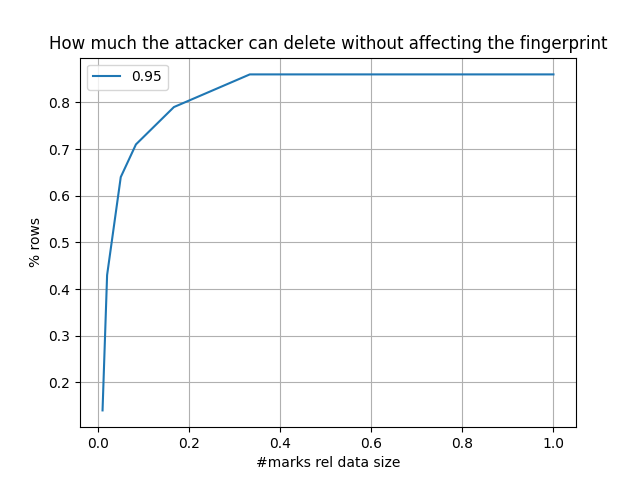

In [26]:
%matplotlib notebook
confidence_rates = [0.95]
n_experiments = 100
for confidence_rate in confidence_rates:
    file_string = 'robustness_vertical_universal_c{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.3. Flipping attack

In [52]:
attack = FlippingAttack()

In [10]:
#robustness_evaluation(attack, data, 'flipping', gammae=[1], confidence_rate=0.95, target='income', n_experiments=1, 
#                      attack_granularity=0.1)

In [55]:
robustness_statistical(attack, data, 'flipping', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.02, confidence_rate=0.95)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.46,
 2: 0.44,
 3: 0.42,
 4: 0.4,
 5: 0.4,
 6: 0.4,
 10: 0.36,
 12: 0.34,
 15: 0.34,
 18: 0.32,
 20: 0.32,
 25: 0.3,
 30: 0.26,
 35: 0.26,
 40: 0.24,
 50: 0.22,
 60: 0.18,
 70: 0.18,
 80: 0.14,
 100: 0.14,
 200: 0.02}

<IPython.core.display.Javascript object>


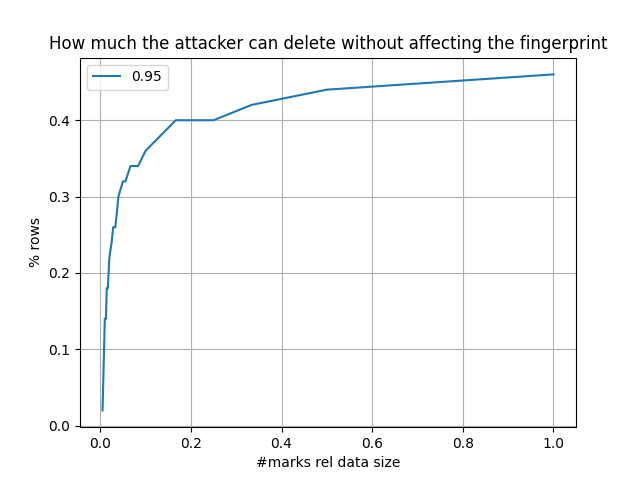

In [57]:
%matplotlib notebook
confidence_rates = [0.95]
attack_granularity= 0.02
for confidence_rate in confidence_rates:
    file_string = 'robustness_stat_flipping_universal_c{}_ag{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                             format(attack_granularity, ".2f")[-2:])
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

In [12]:
resutls

{1: 0.9}

## 2. Attack utility decrease

In [15]:
results = {}
attack_granularity = 0.05
n_folds = 5
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
# check if results exist
# ---------------------- #
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # returns estimated utility drop for each attack strength
    attack_utility_knn = attack_utility_knn(Adult().preprocessed(), target, attack, attack_granularity=attack_granularity, 
                                            n_folds=n_folds)


    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(attack_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')
# ---------------------- #

Results already exist. Not taking any action.


In [71]:
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    attack_utility_knn = pickle.load(infile)
attack_utility_knn = dict(sorted(attack_utility_knn.items()))

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


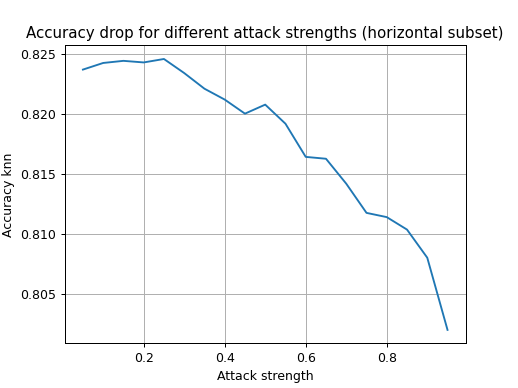

Text(0.5, 1.0, 'Accuracy drop for different attack strengths (horizontal subset)')

In [72]:
%matplotlib
plt.plot(attack_utility_knn.keys(), [np.mean(acc) for acc in attack_utility_knn.values()])
plt.xlabel('Attack strength')
plt.ylabel('Accuracy knn')
plt.title('Accuracy drop for different attack strengths (horizontal subset)')

In [18]:
# original accuracy
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # from how much remaining data can the fingerprint still be extracted?
    original_utility_knn = original_utility_knn(Adult().preprocessed(), target, n_folds=n_folds)

    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(original_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')

Results already exist. Not taking any action.


In [19]:
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    original_utility_knn = pickle.load(infile)

In [20]:
#acceptable_utility_drop = 0.01
#utility_preserving_attack_strength = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=acceptable_utility_drop])
# alternative
# attacks that yield at least 1% of accuracy loss
#attacks_1p = max([strength for strength in attack_utility_knn 
#                  if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.01])
# attacks that yield at least 2% of accuracy loss
#attacks_2p = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.02])
#
#attacks_3p = max([strength for strength in attack_utility_knn
#                 if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.03])

In [21]:
#max_utility_drop = np.mean(original_utility_knn) - min(np.mean(acc) for acc in attack_utility_knn.values())

In [75]:
# retruns a list [attack_with_1%_loss, attack_with_2%_loss, ... , max_abs_utility_loss]
att_utility_bounds = attack_utility_bounds(original_utility_knn, attack_utility_knn) 

<IPython.core.display.Javascript object>


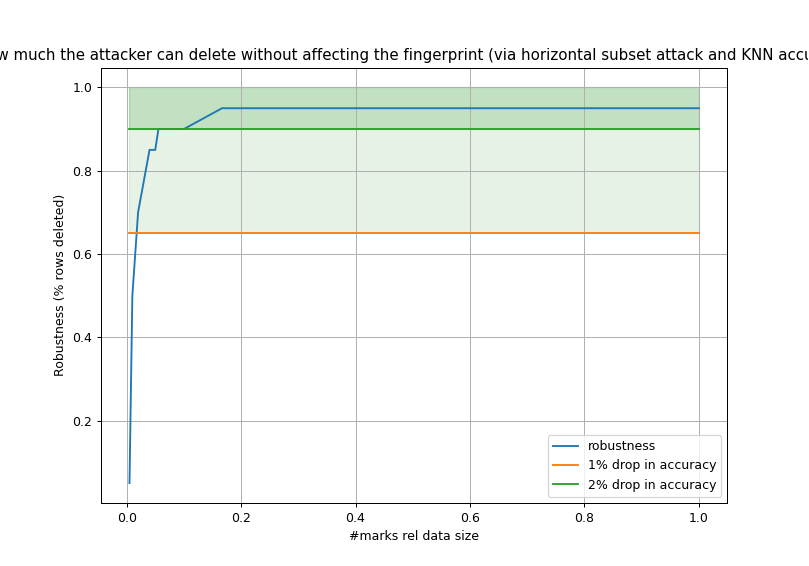

In [76]:
%matplotlib notebook
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)
fig, ax = plt.subplots(figsize=(10, 7))

lines = []
fill = []

lines.append(ax.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], label='robustness'))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], 1.0, color='green', alpha=0.1))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], 1.0, color='green', alpha=0.15))

plt.title('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN accuracy)')
plt.xlabel('#marks rel data size') 
plt.ylabel('Robustness (% rows deleted)')

legend = plt.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]]
graphs[line_legends[1]] = [lines[1][0], fill[0]]
graphs[line_legends[2]] = [lines[2][0], fill[1]]
   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

## 3. Utility after fingerprinting

### 3.1. KNN 

In [86]:
#gammae = [1, 3, 6, 12, 25, 50, 100]
fp_utility_results = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results = pickle.load(infile)
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    fp_utility_knn = fingerprint_utility_knn(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results[gamma] = fp_utility_knn
    
fp_utility_results =  dict(sorted(fp_utility_results.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results, outfile)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


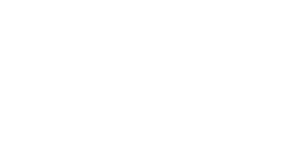

Text(0, 0.5, 'Accuracy knn')

In [87]:
%matplotlib
file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[gamma]]) for gamma in fp_utility_results.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')

### 3.2. Decision Tree

In [88]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_DT = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_DT = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_DT.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_DT.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_dt = fingerprint_utility_dt(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_DT[gamma] = fp_utility_dt
    
fp_utility_results_DT =  dict(sorted(fp_utility_results_DT.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_DT, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


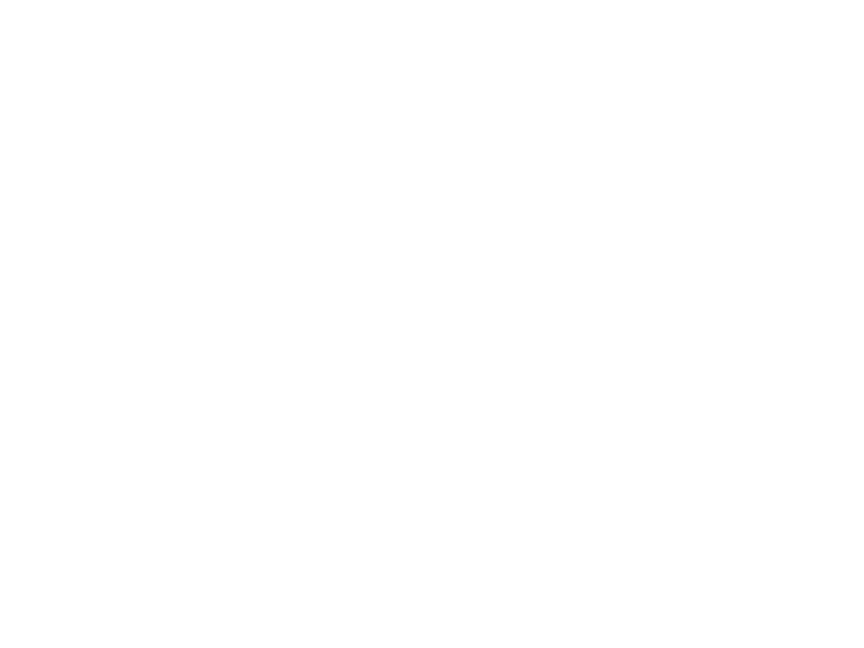

In [89]:
%matplotlib notebook
file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_DT = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_DT.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[gamma]]) for gamma in fp_utility_results_DT.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

### 3.3 Gradient Boosting

In [90]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_GB = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_GB = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_GB.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_GB.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_gb = fingerprint_utility_gb(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_GB[gamma] = fp_utility_gb
    
fp_utility_results_GB =  dict(sorted(fp_utility_results_GB.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_GB, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


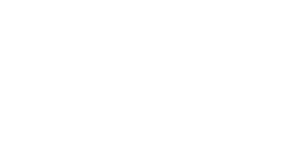

In [91]:
%matplotlib notebook
file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_GB = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_GB.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[gamma]]) for gamma in fp_utility_results_GB.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

## COMBINED RESULTS

In [36]:
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)

In [37]:
# interceptions
x_intercept_0 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[0]]))
x_intercept_1 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[1]]))

<IPython.core.display.Javascript object>


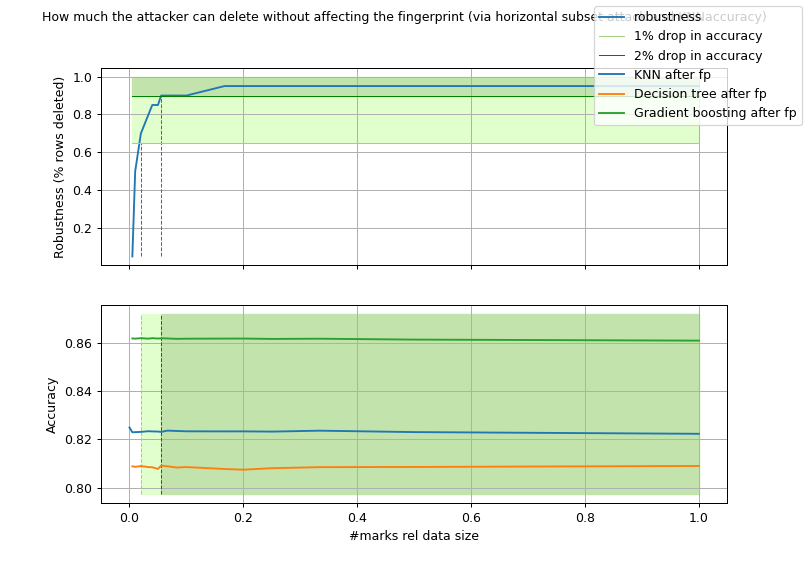

In [98]:
# incorporate in the full analysis
%matplotlib notebook
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7)) # sharey=True

lines = []
fill = []
helpers = []

x_axis = [1.0/g for g in gammae]

# ---------------------------- #
# robustness
# ---------------------------- #
y_robustness = [1 - inv_robustness for inv_robustness in resutls.values()]
lines.append(ax[0].plot(x_axis, y_robustness, label='robustness'))

# --------------------------- #
# utility (start)
# --------------------------- #
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]])
             for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
y_utility_DT = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[g]])
                for g in fp_utility_results_DT.keys()]
y_utility_GB = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[g]])
                for g in fp_utility_results_GB.keys()]
y_utility_all = y_utility + y_utility_DT + y_utility_GB

# --------------------------- #
# attack utility
# --------------------------- #
lw = 0.8
bound_patch = 0.01

lines.append(ax[0].plot(x_axis, [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy', linewidth=lw, 
                        color='#a2d180'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[0] for x in resutls], 1.0, color='#e1ffcc'))
helpers.append(ax[0].vlines(x=x_intercept_0, ymin=min(y_robustness), ymax=att_utility_bounds[0], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_0, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='#a2d180'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_0], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#e1ffcc'))

lines.append(ax[0].plot(x_axis, [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy', linewidth=lw, 
                        color='green'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[1] for x in resutls], 1.0, color='#c3e3ac'))
helpers.append(ax[0].vlines(x=x_intercept_1, ymin=min(y_robustness), ymax=att_utility_bounds[1], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_1, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='green'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_1], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#c3e3ac'))

# todo: mark on the first subplot (ax[0]) when the utility gets way too low; eg. -1%, -2% etc

# ---------------------------- #
# utility
# ---------------------------- #
# KNN
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]]) 
                                    for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
lines.append(ax[1].plot(x_axis+[0.0], y_utility, label='KNN after fp'))
# Decision Tree
lines.append(ax[1].plot(x_axis, y_utility_DT, label='Decision tree after fp'))
# Gradient Boosting
lines.append(ax[1].plot(x_axis, y_utility_GB, label='Gradient boosting after fp'))
ax[1].set_ylabel('Accuracy')
# ---------------------------- #

fig.suptitle('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN' + 
             'accuracy)', size=10)
plt.xlabel('#marks rel data size') 
ax[0].set_ylabel('Robustness (% rows deleted)')

plt.rcParams['axes.grid'] = True

legend = fig.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]] # -> robustness
graphs[line_legends[1]] = [lines[1][0], fill[0], helpers[0], fill[1], helpers[1]] # -> attack utility 
graphs[line_legends[2]] = [lines[2][0], fill[2], helpers[2], fill[3], helpers[3]]
graphs[line_legends[3]] = [lines[3][0]] # -> utility
graphs[line_legends[4]] = [lines[4][0]]
graphs[line_legends[5]] = [lines[5][0]]

   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

Robustness plot (above):
- in the dark green area, the utility of the attacker's data is expected to drop at least 2% for the observed attacks, in addition to the increased robustness for that area. This helps determining the lower boundary on what is considered a robust scheme. Therefore, on the one hand, while choosing the number of marks (x axis), the user can say "if the attacker needs to modify at least 50% of data (i.e. robustness=50%), the scheme is robust", or on the other hand "if the attacker loses more than 2% of accuracy by modifying the data, the scheme is considered robust", or a combination of both. 
- the light green area represents where the utility is expected to drop at least 1% due to the attack strength

Utility plot (below):
- the dark and light green areas are transposed to help find the lower boundary of number of marks that the user wants to chose
- users wants to choose the #marks (x axis) with the highest accuracy
- the idea for the alternative plot regarding utility might be to plot relative delta accuracy (real_acc-original_acc)/original_acc -> for each classifier and cumulative